# Module

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import os
import sys
import dotenv
import nest_asyncio
dotenv.load_dotenv()
import requests
import json
from glob import glob
import time
import pandas as pd
from tqdm import tqdm
from urllib.parse import unquote
from collections import defaultdict
from bs4 import BeautifulSoup

# Setting

In [2]:
api_key = api_key = os.getenv("UPSTAGE_API_KEY")
file_name_list = glob("../data/nursing/*.pdf")
headers = {"Authorization": f"Bearer {api_key}"}
document_parser_url = "https://api.upstage.ai/v1/document-ai/async/document-parse"
document_parser_url_ = "https://api.upstage.ai/v1/document-ai/document-parse"
check_url = "https://api.upstage.ai/v1/document-ai/requests"


# Parsing

In [3]:
files = {"document": open("/home/livin/rag_pipeline/AutoRAG/data/test/nursing_test.pdf", "rb")}
data = {
    "ocr": "force",
    "output_formats": '["markdown", "html", "text"]'
    }
api_response = requests.post(document_parser_url_, headers=headers, files=files, data=data)

In [5]:
api_response.json()

{'api': '2.0',
 'content': {'html': '<header id=\'0\' style=\'font-size:18px\'>CHAPTER 14 호흡기장애 대상자 간호 I 553</header>\n<br><figure><img id=\'1\' alt="" data-coord="top-left:(1144,42); bottom-right:(1318,155)" /></figure>\n<h1 id=\'2\' style=\'font-size:20px\'>표 14-15 폐렴 대상자 간호</h1>\n<br><table id=\'3\' style=\'font-size:14px\'><tr><td>기대되는 결과</td><td>간호</td></tr><tr><td>비효과적인 호흡양상 개선 · 효과적으로 기침하고 호흡함 · 물을 3 L/일 마심 · 활력징후 정상 · 청진 시 폐음 정상 · 지시대로 물을 마심 · 객담을 잘 뱉어냄 · 소변색이 정상임</td><td>· 활력징후와 신체상태를 관찰한다. · 호흡의 횟수, 리듬, 깊이, 노력을 관찰한다. · 흉부의 움직임과 대칭 여부, 보조근의 사용, 쇄골 움직임, 늑간근 수축을 관찰한다. · 호흡양상을 관찰한다. 빈호흡, 빈맥, 과도환기, Kussmaul 호흡, Cheyne-Stokes 호흡, 지속성 흡식 (apneustic) 호흡, Biot 호흡, 실조성(ataxic) 호흡양상 등 · 횡격막의 근육피로를 관찰한다(paradoxical motion). · 호흡음을 청진하여 환기 감소나 결핍부위, 진통음(adventitions)이 틀리는 부위를 기록한다. · 악설음과 천명음을 청진하여 흡인이 필요한지 결정한다. · 동맥혈가스분석 결과를 확인하고, 안절부절못함, 불안 등의 산소부족 증상을 관찰한다. · 효과적인 기침 능력을 관찰한다: 기침의 시작, 특징, 기간 · 호흡기 분비물을 관찰한다. · 호흡곤란을 완화시키거나 악화시키는 요인을 확인한다. · 흉부 X-선 결과를 확인한다. · 심호흡으로 흉곽내 압력을 상승시켜 강하게 숨을

In [13]:
# document_file_name,request_id, download_url 이 컬럼인 df를 만들어서 csv로 저장 하는 로직 구현
df = []
for file_name in tqdm(file_name_list):
    try:
        print(f"{file_name} - Start!")
        files = {"document": open(file_name, "rb")}
        data = {
            "ocr": "force",
            "output_formats": '["markdown", "html", "text"]'
            }
        api_response = requests.post(document_parser_url, headers=headers, files=files, data=data)
        while True:
            check_response = requests.get(os.path.join(check_url, api_response.json()["request_id"]), headers=headers)
            is_completed = False
            for batch in check_response.json()["batches"]:
                if batch["status"] == "completed":
                    is_completed = True
                else:
                    is_completed = False
                    break
            if is_completed:
                print(f"{file_name} - Completed!")
                break
            else:
                time.sleep(10)
        for batch in check_response.json()["batches"]:
            df.append([file_name, api_response.json()["request_id"], batch])
        print(f"==============================================")
    except Exception as e:
        print(f"{file_name} - error")
        print(e)
        continue

# df를 csv로 저장
df = pd.DataFrame(df, columns=["document_file_name", "request_id", "batch"])
df.to_csv("../data/nursing/parse_result_test.csv", index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

/home/livin/rag_pipeline/AutoRAG/data/test/nursing_test.pdf - Start!


100%|██████████| 1/1 [00:20<00:00, 20.61s/it]

/home/livin/rag_pipeline/AutoRAG/data/test/nursing_test.pdf - Completed!


# Check Result

##### Check request_id

In [8]:
check_response = requests.get(check_url, headers=headers).json()["requests"]

##### Downloading 함수 정의

In [25]:
def download_file(url, folder_path):
    # 폴더가 존재하지 않으면 생성
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # 파일 다운로드 시작
    response = requests.get(url, stream=True)
    response.raise_for_status()  # 다운로드가 실패했는지 확인

    file_name = url.split("/")[-1]
    # 파일명을 한글 인코딩을 고려하여 디코딩
    file_name = unquote(file_name).split("?")[0]


    # 저장 경로 지정
    file_path = os.path.join(folder_path, file_name)

    # 파일 저장
    with open(file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print(f"File saved at {file_path}")


##### Downloading

In [ ]:
folder_path = "./downloads"

for check_response_i in check_response:
    if check_response_i["status"] == "completed":
        batch_results = requests.get(os.path.join(check_url, check_response_i["id"]), headers=headers).json()["batches"]
        for batch_result in batch_results:
            download_file(batch_result["download_url"], folder_path)
        print("Completed")
    else:
        print("Not completed yet")
        continue

# File Integration

##### html 파일로 저장

In [3]:
json_file_list = sorted(glob("../data/nursing/nursing_downloads/*"))
file_names = sorted(list(set([name.split(".pdf")[0].split("/")[-1] for name in name_list])))
file_name_to_json = defaultdict(list)

for file_name in file_names:
    for json_file in json_file_list:
        if file_name in json_file:
            file_name_to_json[file_name].append(json_file)

NameError: name 'name_list' is not defined

In [41]:
for file_name in file_name_to_json:
    file_corpus = ""
    for json_file in file_name_to_json[file_name]:
        with open(json_file, "r") as f:
            data_elements = json.load(f)
            for element in data_elements["elements"]:
                file_corpus += element["html"]
    # html 파일로 저장
    with open(f"../data/nursing/nursing_html/{file_name}.html", "w") as f:
        f.write(file_corpus)

##### corpus 파일로 변환 후 저장

In [54]:
df_dict = {"texts":[], "path":[], "page":[], "last_modified_datetime":[]}

In [55]:
for file_name in file_names:
    with open(f"../data/nursing/nursing_html/{file_name}.html", "r") as f:
        html = f.read()
        df_dict["texts"].append(html)
        df_dict["path"].append(file_name)
        df_dict["page"].append(-1)
        df_dict["last_modified_datetime"].append(pd.Timestamp.now())

In [56]:
df = pd.DataFrame(df_dict)

In [58]:
# csv 파일로 저장   
df.to_csv("../data/nursing/corpus/nursing_corpus.csv")

# parquet 파일로 저장   
df.to_parquet("../data/nursing/corpus/nursing_corpus.parquet")

In [6]:
# json 모듈로 파일을 읽기

import json
with open("/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_downloads/23장 내분비장애 대상자 간호.pdf_batch0002_0021_0030.json", "r") as f:
    data = json.load(f)

In [7]:
data

{'api': '1.1',
 'billed_pages': 10,
 'elements': [{'bounding_box': [{'x': 337, 'y': 116},
    {'x': 600, 'y': 116},
    {'x': 600, 'y': 142},
    {'x': 337, 'y': 142}],
   'category': 'header',
   'html': "<header id='0' style='font-size:16px'>UNIT 7 조정장애 대상자 간호</header>",
   'id': 0,
   'page': 21,
   'text': 'UNIT 7 조정장애 대상자 간호'},
  {'bounding_box': [{'x': 249, 'y': 116},
    {'x': 331, 'y': 116},
    {'x': 331, 'y': 143},
    {'x': 249, 'y': 143}],
   'category': 'paragraph',
   'html': "<br><p id='1' data-category='paragraph' style='font-size:18px'>566 I</p>",
   'id': 1,
   'page': 21,
   'text': '566 I'},
  {'bounding_box': [{'x': 185, 'y': 220},
    {'x': 416, 'y': 220},
    {'x': 416, 'y': 247},
    {'x': 185, 'y': 247}],
   'category': 'paragraph',
   'html': "<p id='2' data-category='paragraph' style='font-size:18px'>표 23-3 요붕증 치료약물</p>",
   'id': 2,
   'page': 21,
   'text': '표 23-3 요붕증 치료약물'},
  {'bounding_box': [{'x': 172, 'y': 235},
    {'x': 1186, 'y': 235},
    {'x': 11

# HTML Chunk to Text

In [40]:
# parquet 읽기
df = pd.read_parquet("../results/qa/nursing/corpus_text.parquet")

In [41]:
df["contents"][1230]

'파일 제목: 17장 혈액계 장애 대상자 간호\n 내용: 등\n을 발견할 수 있으며, 예후는 림프구, 혼합형, 조직구의\n순으로 나쁘다.\nWHO에서는 비호지킨림프종을 61개의 아형으로 분\n류하였으나 유전자의 발현 양상에 따라 모호한 저급과\n공격적인 고급 영역으로 분류한다.\nInternational Prognostic Index(IPI)는 각 유형별로 적\n합한 치료방법을 선택하도록 돕는다. 임상적 병기에 포\n함되는 요인은 림프절 외 병소의 수, 혈청 LDH, 백혈구\n수, 혈색소 수준, 연령과 일상생활 수행 정도이다.\n(3) 치료와 간호\n치료는 임상단계, 조직의 유형, 연령, 골수기능에 따\n라 다르다. I, II 단계와 같이 병소가 국한되었을 때 방\n사선치료를 실시한다. 병소가 진행되어 확산된 경우는\n방사선치료와 항암화학요법을 병용한다. III, IV 단계의\n림프종에는 항암화학요법을 실시한다.\n공격적인 림프종은 치료에 반응을 잘 하고 치유도 잘\n된다. 저급 림프종은 진행경과가 길지만 효과적으로 치\n료하기가 어렵다. Helicobacter pylori 위장림프종과 같\n이 감염으로 인한 경우는 항생제나 항바이러스제로 치\n료한다. 공격적이거나 난치성 일부 림프종은 말초 조혈\n모세포이식이 도움이 된다.\ncyclophosphamide(Cytoxan), vincristine sulfate,\nprednisone, procarbazine hydrochloride, doxorubicin\nhydrochloride와 bleomycin 등을 복합적으로 투여하거\n나 fludarabine과 단일 약제를 함께 투여한다. 재발한\n경우에는 monoclonal antibodies(예: rituximab과\nalemtuzumab, ibritumomab tiuxetan: Zevalin, tositu-\nmomab: Bexxar)와 radiolabeled antibodies, 즉 131I\ntositumomab와 90Y'

In [37]:
for i in range(len(df)):
    html_content = df["contents"][i]
    soup = BeautifulSoup(html_content, 'html.parser')
    df.iloc[i]["contents"] = soup.get_text(separator="\n")

In [38]:
df["contents"][1230]

'파일 제목: 17장 혈액계 장애 대상자 간호\n 내용: 등\n을 발견할 수 있으며, 예후는 림프구, 혼합형, 조직구의\n순으로 나쁘다.\nWHO에서는 비호지킨림프종을 61개의 아형으로 분\n류하였으나 유전자의 발현 양상에 따라 모호한 저급과\n공격적인 고급 영역으로 분류한다.\nInternational Prognostic Index(IPI)는 각 유형별로 적\n합한 치료방법을 선택하도록 돕는다. 임상적 병기에 포\n함되는 요인은 림프절 외 병소의 수, 혈청 LDH, 백혈구\n수, 혈색소 수준, 연령과 일상생활 수행 정도이다.\n(3) 치료와 간호\n치료는 임상단계, 조직의 유형, 연령, 골수기능에 따\n라 다르다. I, II 단계와 같이 병소가 국한되었을 때 방\n사선치료를 실시한다. 병소가 진행되어 확산된 경우는\n방사선치료와 항암화학요법을 병용한다. III, IV 단계의\n림프종에는 항암화학요법을 실시한다.\n공격적인 림프종은 치료에 반응을 잘 하고 치유도 잘\n된다. 저급 림프종은 진행경과가 길지만 효과적으로 치\n료하기가 어렵다. Helicobacter pylori 위장림프종과 같\n이 감염으로 인한 경우는 항생제나 항바이러스제로 치\n료한다. 공격적이거나 난치성 일부 림프종은 말초 조혈\n모세포이식이 도움이 된다.\ncyclophosphamide(Cytoxan), vincristine sulfate,\nprednisone, procarbazine hydrochloride, doxorubicin\nhydrochloride와 bleomycin 등을 복합적으로 투여하거\n나 fludarabine과 단일 약제를 함께 투여한다. 재발한\n경우에는 monoclonal antibodies(예: rituximab과\nalemtuzumab, ibritumomab tiuxetan: Zevalin, tositu-\nmomab: Bexxar)와 radiolabeled antibodies, 즉 131I\ntositumomab와 90Y'

In [39]:
# parquet 파일로 저장
df.to_parquet("../results/qa/nursing/corpus_text.parquet")

In [5]:
file_name, html_content = html_content.split("내용: ")

In [6]:
html_content

'<h1 id=\'0\' style=\'font-size:20px\'>강의용 자료파일 사용 안내</h1><p id=\'1\' data-category=\'list\' style=\'font-size:16px\'>1. 이 파일은 본 교재의 내용을 바탕으로 원활한<br>강의 진행에 도움을 드리고자 제작된 교수님<br>전용 파일입니다.<br>2. 해당 교과목 담당 교수님을 제외한 제3자에게<br>이 파일을 전송 및 배포(업로드/다운로드)하는<br>것을 금합니다.</p><footer id=\'2\' style=\'font-size:14px\'>의학/간호/보건 전문출판<br>Hyunmoon m 현문사</footer><h1 id=\'3\' style=\'font-size:18px\'>제8판</h1><br><h1 id=\'4\' style=\'font-size:22px\'>성인간호학 I 하권|</h1><br><p id=\'5\' data-category=\'paragraph\' style=\'font-size:16px\'>MEDICAL SURGICAL NURSING</p><br><p id=\'6\' data-category=\'paragraph\' style=\'font-size:14px\'>Eighth Edition</p><p id=\'7\' data-category=\'paragraph\' style=\'font-size:14px\'>대표저자 유양숙 권보은 김희경 박영례 박효미 안경주 엄미란 은 영 조경숙 최승혜</p><br><figure><img id=\'8\' style=\'font-size:20px\' alt="양 子\nIm 현문사" data-coord="top-left:(62,734); bottom-right:(1313,1715)" /></figure><p id=\'9\' data-category=\'paragraph\' style=\'font-size:18px\'>/unmo 현문사</p><p id=\'10\' data-category=\'paragraph\' 

In [9]:
soup = BeautifulSoup(html_content, 'html.parser')

In [10]:
text = soup.get_text(separator="\n")

In [11]:
text

'강의용 자료파일 사용 안내\n1. 이 파일은 본 교재의 내용을 바탕으로 원활한\n강의 진행에 도움을 드리고자 제작된 교수님\n전용 파일입니다.\n2. 해당 교과목 담당 교수님을 제외한 제3자에게\n이 파일을 전송 및 배포(업로드/다운로드)하는\n것을 금합니다.\n의학/간호/보건 전문출판\nHyunmoon m 현문사\n제8판\n성인간호학 I 하권|\nMEDICAL SURGICAL NURSING\nEighth Edition\n대표저자 유양숙 권보은 김희경 박영례 박효미 안경주 엄미란 은 영 조경숙 최승혜\n/unmo 현문사\n일러두기\n* 해부학용어는 대한의사협회 의학용어 4,5판에 근거하여 옛용어와 새용어를 병기하였으\n며, 질환명의 일부는 새용어를 소개하는 정도로 제시함\n* 본문 중 영문표기는 일반명사와 상품화된 약품명 등의 혼동을 우려해 고유명사와 상품\n명을 제외하고 모두 소문자로 표기함\n* 수술법이나 증상에 관한 부분은 설명으로 부족한 부분에 한하여 QR 코드를 제시하여 동\n영상을 바로 볼 수 있도록 함(동영상 주소는 변동 가능함)\n최근 코로나 팬데믹 상황으로 인하여 우리의 삶과 일상은 물론 교육환경도 많이 바뀌었습니다. 이론교육이\n온라인으로 이루어지고, 경험을 통해 배워야 하는 현장실습이 제한됨에'

In [13]:
result

'강의용 자료파일 사용 안내1. 이 파일은 본 교재의 내용을 바탕으로 원활한강의 진행에 도움을 드리고자 제작된 교수님전용 파일입니다.2. 해당 교과목 담당 교수님을 제외한 제3자에게이 파일을 전송 및 배포(업로드/다운로드)하는것을 금합니다.의학/간호/보건 전문출판Hyunmoon m 현문사제8판성인간호학 I 하권|MEDICAL SURGICAL NURSINGEighth Edition대표저자 유양숙 권보은 김희경 박영례 박효미 안경주 엄미란 은 영 조경숙 최승혜/unmo 현문사일러두기* 해부학용어는 대한의사협회 의학용어 4,5판에 근거하여 옛용어와 새용어를 병기하였으며, 질환명의 일부는 새용어를 소개하는 정도로 제시함* 본문 중 영문표기는 일반명사와 상품화된 약품명 등의 혼동을 우려해 고유명사와 상품명을 제외하고 모두 소문자로 표기함* 수술법이나 증상에 관한 부분은 설명으로 부족한 부분에 한하여 QR 코드를 제시하여 동영상을 바로 볼 수 있도록 함(동영상 주소는 변동 가능함)최근 코로나 팬데믹 상황으로 인하여 우리의 삶과 일상은 물론 교육환경도 많이 바뀌었습니다. 이론교육이'

In [42]:
from schema import Schema, And, Use

In [1]:
from glob import glob

In [2]:
paths = glob("/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/*html")

In [5]:
paths

['/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/25장 청각과 평형장애 대상자 간호.html',
 '/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/22장 신경계장애 대상자간호-(1).html',
 '/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/14장 호흡기장애 대상자 간호-(2).html',
 '/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/24장 시각장애 대상자 간호.html',
 '/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/30 판권.html',
 '/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/15장 심장장애 대상자 간호-(2).html',
 '/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/18장 요로계 장애 대상자 간호.html',
 '/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/00 도입부(하권).html',
 '/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/21장 근골격계 장애.html',
 '/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/16장 혈관장애 대상자 간호.html',
 '/home/livin/rag_pip

In [7]:
"""
{
  "collection_name": "nursing_html_bgem3",
  "document_paths": [
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/25장 청각과 평형장애 대상자 간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/22장 신경계장애 대상자간호-(1).html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/14장 호흡기장애 대상자 간호-(2).html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/24장 시각장애 대상자 간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/30 판권.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/15장 심장장애 대상자 간호-(2).html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/18장 요로계 장애 대상자 간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/00 도입부(하권).html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/21장 근골격계 장애.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/16장 혈관장애 대상자 간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/26장 피부장애 대상자 간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/19장 남성 생식기계 대상자 간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/23장 내분비장애 대상자 간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/22장 신경계장애 대상자간호-(2).html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/15장 심장장애 대상자 간호-(1).html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/20장 유방장애 대상자 간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/17장 혈액계 장애 대상자 간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/27장 화상간호.html",
    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/14장 호흡기장애 대상자 간호-(1).html"
  ],
  "chunk_size": 1024,
  "chunk_overlap": 200
}
"""

'\n{\n  "collection_name": "nursing_html_bgem3",\n  "document_paths": [\n    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/25장 청각과 평형장애 대상자 간호.html",\n    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/22장 신경계장애 대상자간호-(1).html",\n    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/14장 호흡기장애 대상자 간호-(2).html",\n    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/24장 시각장애 대상자 간호.html",\n    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/30 판권.html",\n    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/15장 심장장애 대상자 간호-(2).html",\n    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/18장 요로계 장애 대상자 간호.html",\n    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/00 도입부(하권).html",\n    "/home/livin/rag_pipeline/AutoRAG/data/nursing/nursing_html/21장 근골격계 장애.html",\n    "/home/l

In [16]:
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [58]:
result = {'api': '2.0',
 'content': {'html': '<header id=\'0\' style=\'font-size:18px\'>CHAPTER 14 호흡기장애 대상자 간호 I 553</header>\n<br><figure><img id=\'1\' alt="" data-coord="top-left:(1144,42); bottom-right:(1318,155)" /></figure>\n<h1 id=\'2\' style=\'font-size:20px\'>표 14-15 폐렴 대상자 간호</h1>\n<br><table id=\'3\' style=\'font-size:14px\'><tr><td>기대되는 결과</td><td>간호</td></tr><tr><td>비효과적인 호흡양상 개선 · 효과적으로 기침하고 호흡함 · 물을 3 L/일 마심 · 활력징후 정상 · 청진 시 폐음 정상 · 지시대로 물을 마심 · 객담을 잘 뱉어냄 · 소변색이 정상임</td><td>· 활력징후와 신체상태를 관찰한다. · 호흡의 횟수, 리듬, 깊이, 노력을 관찰한다. · 흉부의 움직임과 대칭 여부, 보조근의 사용, 쇄골 움직임, 늑간근 수축을 관찰한다. · 호흡양상을 관찰한다. 빈호흡, 빈맥, 과도환기, Kussmaul 호흡, Cheyne-Stokes 호흡, 지속성 흡식 (apneustic) 호흡, Biot 호흡, 실조성(ataxic) 호흡양상 등 · 횡격막의 근육피로를 관찰한다(paradoxical motion). · 호흡음을 청진하여 환기 감소나 결핍부위, 진통음(adventitions)이 틀리는 부위를 기록한다. · 악설음과 천명음을 청진하여 흡인이 필요한지 결정한다. · 동맥혈가스분석 결과를 확인하고, 안절부절못함, 불안 등의 산소부족 증상을 관찰한다. · 효과적인 기침 능력을 관찰한다: 기침의 시작, 특징, 기간 · 호흡기 분비물을 관찰한다. · 호흡곤란을 완화시키거나 악화시키는 요인을 확인한다. · 흉부 X-선 결과를 확인한다. · 심호흡으로 흉곽내 압력을 상승시켜 강하게 숨을 내뱉는 기침을 하도록 권장한다. · 유발폐활량계를 사용하도록 권장한다. · 충분한 수분을 공급하고 섭취량과 배설량을 측정한다.</td></tr><tr><td>가스교환 장애 개선</td><td>·</td></tr><tr><td>· 불편감 없이 호흡함 · 말초산소포화도와 동맥혈가스분석 결과가 정상범위임</td><td>· 휴식, 운동, 수면 시 호흡곤란을 사정한다. · 구강, 비강, 기관지 등의 분비물을 제거하여 기도개방을 유지한다. 금연한다. · 가온 · 가습기구를 통해 산소를 지시대로 투여한다. · 대상자와 가족에게 산소요법 원리를 설명한다. · 식사 시 산소공급기구를 마스크에서 비강캐뉼러로 바꾸어준다. · 저환기 징후를 관찰한다. · 산소독성과 무기폐 징후를 관찰한다. · 대상자가 이동할 때 산소를 제공한다.</td></tr><tr><td>질병과 관련된 지식제공 · 폐렴의 위험요인을 피함 · 추후관리를 잘 이행함</td><td>· 폐렴의 위험요인, 치료, 합병증의 예방과 조기 발견 방법에 대하여 교육한다.</td></tr></table>\n<br><p id=\'4\' data-category=\'paragraph\' style=\'font-size:14px\'>· 예방의 중요성을 이해함</p>\n<p id=\'5\' data-category=\'paragraph\' style=\'font-size:20px\'>Box 14-20 폐렴 예방을 위한 교육</p>\n<br><p id=\'6\' data-category=\'paragraph\' style=\'font-size:20px\'>잠깐!!</p>\n<p id=\'7\' data-category=\'list\' style=\'font-size:16px\'>· 금연한다.<br>· 사람이 많이 모이는 곳을 피한다.<br>· 폐렴의 위험요인을 피하고 매년 인플루엔자 백신을 접종한다.<br>· 와상 또는 부동상태인 경우 자주 기침과 체위변경, 심호흡을 하<br>도록 한다.<br>· 가정에서 사용하는 호흡치료기구를 청결하게 한다.<br>· 먼지나 간접흡연, 분무기 같은 실내 오염물질을 제거한다.<br>· 충분한 휴식과 수면, 균형잡힌 식사 및 수분을 섭취한다.</p>\n<br><p id=\'8\' data-category=\'paragraph\' style=\'font-size:16px\'>만성질환, 호흡기질환이 있는 50세 이상이나 면역기능이 저하된 대<br>상자는 매년 독감 예방접종을 하고, 폐렴구균백신도 접종한다.</p>\n<p id=\'9\' data-category=\'paragraph\' style=\'font-size:20px\'>4. 폐결핵 Pulmonary tuberculosis</p>\n<br><p id=\'10\' data-category=\'paragraph\' style=\'font-size:22px\'>결핵은 우리나라의 2급 감염병으로 분류되는 감염성<br>이 높은 질환으로 후두, 신장(콩팥), 뼈, 부신, 림프절,<br>뇌막 등 인체 어느 기관에나 전파될 수 있는데, 그중 폐<br>를 가장 잘 침범한다. 세계보건기구(WHO)의 2020년도<br>보고서에 따르면 2019년 전세계 결핵환자는 1,000만 명<br>정도로 추정되었고, 이는 전년 대비 2.3 % 감소한 것이</p>\n<p id=\'11\' data-category=\'paragraph\' style=\'font-size:14px\'>532 I UNIT 3 산소 공급장애 대상자 간호</p>\n<p id=\'12\' data-category=\'paragraph\' style=\'font-size:18px\'>생긴 비염의 경우는 원인 약물을 중지한다. 스테로이드<br>코 스프레이는 약물 중단 후 즉시 나타나는 반동성 비<br>울혈을 감소시키기 위해 사용한다.</p>\n<p id=\'13\' data-category=\'paragraph\' style=\'font-size:18px\'>잠깐!!</p>\n<p id=\'14\' data-category=\'paragraph\' style=\'font-size:14px\'>항히스타민제는 음주(알코올)만큼 심각하게 운전에 지장을 준다.<br>1세대 항히스타민제 디펜히드라민(diphenhydramine) 복용 후의 운<br>전은 알코올보다 더 위험할 수 있다.</p>\n<p id=\'15\' data-category=\'paragraph\' style=\'font-size:18px\'>(2) 간호</p>\n<br><p id=\'16\' data-category=\'paragraph\' style=\'font-size:18px\'>비염 대상자를 위한 간호와 교육내용은 Box 14-12<br>와 같다. 합병증이 발생하지 않으면 7~10일 이내에 회<br>복된다. 알레르기비염이 반복되면 원인을 확인하기 위<br>해 알레르기원 검사를 받도록 한다. 대상자는 알레르기<br>원을 피하거나 탈감작요법(탈민감요법, desensitization<br>therapy)으로 비염의 재발을 예방할 수 있다.</p>\n<p id=\'17\' data-category=\'paragraph\' style=\'font-size:18px\'>3. 부비동염(굴염) Sinusitis</p>\n<br><p id=\'18\' data-category=\'paragraph\' style=\'font-size:18px\'>부비동염은 부비동(코곁굴)점막에 염증성 변화가 초<br>래된 상태로, 흔히 비염을 앓은 후에 발생하며 주 증상<br>은 화농성 또는 점액성 콧물이다. 부비동염을 초래할<br>수 있는 또 다른 요인은 비중격만곡증, 폴립, 종양, 코카<br>인이나 오염된 공기 흡입, 안면외상, 비강삽관, 치아감<br>염, 면역력 저하 등이다. 만성에서는 반복적인 염증으<br>로 점막이 영구적으로 두꺼워진다.</p>\n<p id=\'19\' data-category=\'paragraph\' style=\'font-size:14px\'>Box 14-12 비염 대상자 간호와 교육</p>\n<p id=\'20\' data-category=\'list\' style=\'font-size:14px\'>· 충분한 휴식을 취한다.<br>· 적어도 1일 2~3 L의 수분을 섭취한다.<br>· 처방된 약물을 1일 2~3회 투여한다.<br>· 감염이 퍼지는 것을 예방해야 한다.<br>- 양쪽 콧구멍이 열려있는 상태에서 코를 풀어 염증성 물질<br>이 유스타키오관으로 퍼지지 않도록 한다.<br>- 기침과 재채기를 할 때는 휴지로 입을 가린다.<br>- 사람이 많이 모이는 곳이나 알레르기원에 노출되는 것을<br>피한다.<br>- 손을 자주 씻고, 특히 기침이나 재채기 후에는 반드시<br>씻는다.<br>- 고열, 심한 흉통, 이통(귀통증, ear ache)이 2주 이상<br>지속되거나 감기가 재발되면 병원치료를 받는다.</p>\n<br><p id=\'21\' data-category=\'paragraph\' style=\'font-size:20px\'>대개는 둘 이상의 부비동에 동시에 침범되며, 전체 부<br>비동에 침범된 경우를 범부비동염 (pansinusitis)이라고<br>한다. 이환 빈도는 상악동(위턱굴), 사골동(벌집굴), 전<br>두동(이마굴)이 흔하고 후사골동(뒤벌집굴)이나 접형동<br>(나비굴)은 상대적으로 낮다.</p>\n<br><p id=\'22\' data-category=\'paragraph\' style=\'font-size:16px\'>가장 흔한 원인균은 바이러스로 인한 감기 이후 세균<br>성 감염으로 streptococcus pneumoniae, baemopbilus<br>influenza, bacteroides, moraxella catarrbalis 등이다.</p>\n<p id=\'23\' data-category=\'paragraph\' style=\'font-size:20px\'>1) 임상증상과 진단검사</p>\n<br><p id=\'24\' data-category=\'paragraph\' style=\'font-size:18px\'>증상은 코점막이 붉고 종창이 있으며 두통, 안면 압박<br>감, 통증(머리를 숙이면 더 심해진다), 침범된 부위 촉<br>진 시 압통, 미열, 기침, 화농성 혹은 혈액섞인 분비물<br>등이다. 통증은 염증이 있는 부비동(코곁굴)의 위치에<br>따라 다르다(그림 14-33). 급성부비동염(급성굴염: 발<br>생 3주 미만)이 반복되거나 아급성(3주 이상~3달), 만<br>성(3달 이상)으로 진전되면 1년 내내 모호한 증상이 계<br>속된다.</p>\n<br><p id=\'25\' data-category=\'paragraph\' style=\'font-size:18px\'>진단은 증상과 병력을 근거로 내린다. 염증이 있으면<br>조명투과성(transillumination)이 감소한다. 진단검사로<br>는 부비동촬영, CT, 내시경검사, 비강도말(nasal smear)<br>등이 있다.</p>\n<p id=\'26\' data-category=\'paragraph\' style=\'font-size:22px\'>2) 치료와 간호</p>\n\n<figure><img id=\'28\' style=\'font-size:14px\' alt="전두동(이마굴) 통증부위 사골동(벌집굴) 통증부위\n상악동(위턱굴) 통증부위" data-coord="top-left:(721,1216); bottom-right:(1172,1580)" /><br><figcaption id=\'27\' style=\'font-size:18px\'>급성부비동염의 치료원칙은 적절한 항생제 투여, 배<br>액과 환기 유지, 유발요인의 제거이다. 통증을 완화시<br>키기 위해 codeine, meperidine, morphine 등 진통제</figcaption></figure>\n<br><p id=\'29\' data-category=\'paragraph\' style=\'font-size:16px\'>그림 14-33 부비동(코곁굴) 통증 위치와 방사부위</p>\n<header id=\'30\' style=\'font-size:16px\'>CHAPTER 14 호흡기장애 대상자 간호  577</header>\n<br><figure><img id=\'31\' alt="" data-coord="top-left:(1147,43); bottom-right:(1318,155)" /></figure>\n<p id=\'32\' data-category=\'paragraph\' style=\'font-size:14px\'>성</p>\n<p id=\'33\' data-category=\'paragraph\' style=\'font-size:16px\'>자극은</p>\n<br><p id=\'34\' data-category=\'paragraph\' style=\'font-size:16px\'>초래하고</p>\n<br><p id=\'35\' data-category=\'paragraph\' style=\'font-size:16px\'>킨다.</p>\n<br><p id=\'36\' data-category=\'paragraph\' style=\'font-size:16px\'>지벽이</p>\n<br><p id=\'37\' data-category=\'paragraph\' style=\'font-size:16px\'>함께</p>\n<br><p id=\'38\' data-category=\'paragraph\' style=\'font-size:16px\'>방해한다.</p>\n<br><figure><img id=\'39\' style=\'font-size:14px\' alt="천식: 기도는 기관지경련, 점막의 부종 중심세엽성(centriacinar 또는\n종창, 비대한 점액분비샘의 진하고 centrilobular) 폐기종: 호흡세\n끈끈한 점액생성에 과잉 반응한다. 기관지에 영향을 미치며, 일반\n기도폐쇄는 보통 간헐적이고 가역적이다. 적으로 폐 상부에서 더 심하다.\n페기종: 페 단백분해효소가 세기관지와 폐포의 벽을\n허탈시킨다. 이 벽들이 허탈될 때, 세기관지와 폐포가 탄력성\n을 잃는다. 호기 동안 공기가 포획되어 폐는 과팽창한다.\n만성기관지염: 감염이나 기관지\n분비물 증가, 부종을\n섬모청소율을 저하시\n기관지벽의 염증으로 기관\n비후되어 과도한 점액과 범세엽성(panacinar 또는 panlobular) 폐기종:\n기도를 막아 가스교환을 전 폐포단위에 영향을 미친다. 일반적으로\n하부 폐에서 더 심하다.\nyunmoon" data-coord="top-left:(204,196); bottom-right:(1170,896)" /></figure>\n<h1 id=\'40\' style=\'font-size:18px\'>1. 기관지천식 Bronchial asthma</h1>\n<br><p id=\'41\' data-category=\'paragraph\' style=\'font-size:20px\'>기관지천식은 공기유통에 장애가 있는 상태로 만성적<br>인 기도염증, 기도과민반응과 가역적인 기도페쇄가 나타<br>난다. 기도염증은 세기관지 과민반응을 유발하며, 기도<br>과민반응은 평활근(민무늬근)을 수축시켜 기도협착을<br>일으킨다. 기관지천식의 특성은 표 14-24와 같다.</p>\n<br><p id=\'42\' data-category=\'paragraph\' style=\'font-size:20px\'>그림 14-52 폐쇄성폐질환의 병태생리</p>\n<h1 id=\'43\' style=\'font-size:22px\'>1) 병태생리와 원인</h1>\n<br><p id=\'44\' data-category=\'paragraph\' style=\'font-size:20px\'>천식의 병태생리에는 기도염증, 가역적인 기도폐색,<br>기관지과민반응이 수반된다(그림 14-53).</p>\n<br><p id=\'45\' data-category=\'paragraph\' style=\'font-size:20px\'>염증기전은 급성, 아급성, 만성으로 나타날 수 있다.<br>내·외적 자극에 대한 반응으로 기도부종과 점액분비로<br>기도폐색과 기관지수축이 발생한다. 단핵세포와 호산<br>구의 침윤, 점액의 과잉분비, 상피세포의 표피탈락, 평<br>활근 과잉증식, 기도의 구조변화가 나타난다. 기도염증<br>에 관여하는 주요 세포는 비만세포, 호산구, 상피세포,<br>대식(큰포식)세포, 활성화된 T-림프구이다. T-림프구는<br>수많은 사이토카인을 분비하여 기도염증을 조절하는 역</p>\n<br><h1 id=\'46\' style=\'font-size:22px\'>사</h1>\n<p id=\'47\' data-category=\'paragraph\' style=\'font-size:18px\'>표 14-24 기관지천식의 특성</p>\n<br><p id=\'48\' data-category=\'paragraph\' style=\'font-size:18px\'>발생요인</p>\n<br><table id=\'49\' style=\'font-size:14px\'><tr><td>· 나이</td><td rowspan="3" colspan="2">· 일반적으로 40세 이하에서 발병 · 흔하지 않음 · 알레르기 비염, 습진, 천식 가족력</td></tr><tr><td>· 흡연력</td></tr><tr><td>* 가족력</td></tr><tr><td colspan="3">임상증상</td></tr><tr><td>* 증상발현</td><td colspan="2">· 이른 아침이나 밤, 간헐적으로 나타남. 상황에 따라 다름</td></tr><tr><td>· 호흡곤란</td><td colspan="2">· 천식 악화, 건강이 나빠질 때 외에는 발 현하지 않음</td></tr><tr><td>· 객담</td><td colspan="2">· 드물게 있음, 호산구 증가</td></tr><tr><td colspan="3">진단검사</td></tr><tr><td>· 동맥혈가스분석검사</td><td>· 발작 초기</td><td>지연 시</td></tr><tr><td>- pH</td><td></td><td></td></tr><tr><td>- PaO2</td><td>1</td><td>1</td></tr><tr><td>- PaCO2</td><td></td><td></td></tr><tr><td>· 흉부 X-선검사</td><td>· 폐의 과팽창</td><td></td></tr><tr><td>· 폐활량</td><td>· 감소</td><td></td></tr><tr><td>· 전폐용적</td><td>· 증가</td><td></td></tr><tr><td>· 잔기량</td><td>· 증가</td><td></td></tr><tr><td>· FEV,</td><td>· 감소</td><td></td></tr></table>',
  'markdown': 'CHAPTER 14 호흡기장애 대상자 간호 I 553\n\n\n\n# 표 14-15 폐렴 대상자 간호\n\n| 기대되는 결과 | 간호 |\n| --- | --- |\n| 비효과적인 호흡양상 개선 · 효과적으로 기침하고 호흡함 · 물을 3 L/일 마심 · 활력징후 정상 · 청진 시 폐음 정상 · 지시대로 물을 마심 · 객담을 잘 뱉어냄 · 소변색이 정상임 | · 활력징후와 신체상태를 관찰한다. · 호흡의 횟수, 리듬, 깊이, 노력을 관찰한다. · 흉부의 움직임과 대칭 여부, 보조근의 사용, 쇄골 움직임, 늑간근 수축을 관찰한다. · 호흡양상을 관찰한다. 빈호흡, 빈맥, 과도환기, Kussmaul 호흡, Cheyne-Stokes 호흡, 지속성 흡식 (apneustic) 호흡, Biot 호흡, 실조성(ataxic) 호흡양상 등 · 횡격막의 근육피로를 관찰한다(paradoxical motion). · 호흡음을 청진하여 환기 감소나 결핍부위, 진통음(adventitions)이 틀리는 부위를 기록한다. · 악설음과 천명음을 청진하여 흡인이 필요한지 결정한다. · 동맥혈가스분석 결과를 확인하고, 안절부절못함, 불안 등의 산소부족 증상을 관찰한다. · 효과적인 기침 능력을 관찰한다: 기침의 시작, 특징, 기간 · 호흡기 분비물을 관찰한다. · 호흡곤란을 완화시키거나 악화시키는 요인을 확인한다. · 흉부 X-선 결과를 확인한다. · 심호흡으로 흉곽내 압력을 상승시켜 강하게 숨을 내뱉는 기침을 하도록 권장한다. · 유발폐활량계를 사용하도록 권장한다. · 충분한 수분을 공급하고 섭취량과 배설량을 측정한다. |\n| 가스교환 장애 개선 | · |\n| · 불편감 없이 호흡함 · 말초산소포화도와 동맥혈가스분석 결과가 정상범위임 | · 휴식, 운동, 수면 시 호흡곤란을 사정한다. · 구강, 비강, 기관지 등의 분비물을 제거하여 기도개방을 유지한다. 금연한다. · 가온 · 가습기구를 통해 산소를 지시대로 투여한다. · 대상자와 가족에게 산소요법 원리를 설명한다. · 식사 시 산소공급기구를 마스크에서 비강캐뉼러로 바꾸어준다. · 저환기 징후를 관찰한다. · 산소독성과 무기폐 징후를 관찰한다. · 대상자가 이동할 때 산소를 제공한다. |\n| 질병과 관련된 지식제공 · 폐렴의 위험요인을 피함 · 추후관리를 잘 이행함 | · 폐렴의 위험요인, 치료, 합병증의 예방과 조기 발견 방법에 대하여 교육한다. |\n\n\n· 예방의 중요성을 이해함\n\nBox 14-20 폐렴 예방을 위한 교육\n\n잠깐!!\n\n- · 금연한다.\n- · 사람이 많이 모이는 곳을 피한다.\n- · 폐렴의 위험요인을 피하고 매년 인플루엔자 백신을 접종한다.\n- · 와상 또는 부동상태인 경우 자주 기침과 체위변경, 심호흡을 하\n- 도록 한다.\n- · 가정에서 사용하는 호흡치료기구를 청결하게 한다.\n- · 먼지나 간접흡연, 분무기 같은 실내 오염물질을 제거한다.\n- · 충분한 휴식과 수면, 균형잡힌 식사 및 수분을 섭취한다.\n\n\n만성질환, 호흡기질환이 있는 50세 이상이나 면역기능이 저하된 대\n상자는 매년 독감 예방접종을 하고, 폐렴구균백신도 접종한다.\n\n4. 폐결핵 Pulmonary tuberculosis\n\n결핵은 우리나라의 2급 감염병으로 분류되는 감염성\n이 높은 질환으로 후두, 신장(콩팥), 뼈, 부신, 림프절,\n뇌막 등 인체 어느 기관에나 전파될 수 있는데, 그중 폐\n를 가장 잘 침범한다. 세계보건기구(WHO)의 2020년도\n보고서에 따르면 2019년 전세계 결핵환자는 1,000만 명\n정도로 추정되었고, 이는 전년 대비 2.3 % 감소한 것이\n\n532 I UNIT 3 산소 공급장애 대상자 간호\n\n생긴 비염의 경우는 원인 약물을 중지한다. 스테로이드\n코 스프레이는 약물 중단 후 즉시 나타나는 반동성 비\n울혈을 감소시키기 위해 사용한다.\n\n잠깐!!\n\n항히스타민제는 음주(알코올)만큼 심각하게 운전에 지장을 준다.\n1세대 항히스타민제 디펜히드라민(diphenhydramine) 복용 후의 운\n전은 알코올보다 더 위험할 수 있다.\n\n(2) 간호\n\n비염 대상자를 위한 간호와 교육내용은 Box 14-12\n와 같다. 합병증이 발생하지 않으면 7~10일 이내에 회\n복된다. 알레르기비염이 반복되면 원인을 확인하기 위\n해 알레르기원 검사를 받도록 한다. 대상자는 알레르기\n원을 피하거나 탈감작요법(탈민감요법, desensitization\ntherapy)으로 비염의 재발을 예방할 수 있다.\n\n3. 부비동염(굴염) Sinusitis\n\n부비동염은 부비동(코곁굴)점막에 염증성 변화가 초\n래된 상태로, 흔히 비염을 앓은 후에 발생하며 주 증상\n은 화농성 또는 점액성 콧물이다. 부비동염을 초래할\n수 있는 또 다른 요인은 비중격만곡증, 폴립, 종양, 코카\n인이나 오염된 공기 흡입, 안면외상, 비강삽관, 치아감\n염, 면역력 저하 등이다. 만성에서는 반복적인 염증으\n로 점막이 영구적으로 두꺼워진다.\n\nBox 14-12 비염 대상자 간호와 교육\n\n- · 충분한 휴식을 취한다.\n- · 적어도 1일 2~3 L의 수분을 섭취한다.\n- · 처방된 약물을 1일 2~3회 투여한다.\n- · 감염이 퍼지는 것을 예방해야 한다.\n- - 양쪽 콧구멍이 열려있는 상태에서 코를 풀어 염증성 물질\n- 이 유스타키오관으로 퍼지지 않도록 한다.\n- - 기침과 재채기를 할 때는 휴지로 입을 가린다.\n- - 사람이 많이 모이는 곳이나 알레르기원에 노출되는 것을\n- 피한다.\n- - 손을 자주 씻고, 특히 기침이나 재채기 후에는 반드시\n- 씻는다.\n- - 고열, 심한 흉통, 이통(귀통증, ear ache)이 2주 이상\n- 지속되거나 감기가 재발되면 병원치료를 받는다.\n\n\n대개는 둘 이상의 부비동에 동시에 침범되며, 전체 부\n비동에 침범된 경우를 범부비동염 (pansinusitis)이라고\n한다. 이환 빈도는 상악동(위턱굴), 사골동(벌집굴), 전\n두동(이마굴)이 흔하고 후사골동(뒤벌집굴)이나 접형동\n(나비굴)은 상대적으로 낮다.\n\n가장 흔한 원인균은 바이러스로 인한 감기 이후 세균\n성 감염으로 streptococcus pneumoniae, baemopbilus\ninfluenza, bacteroides, moraxella catarrbalis 등이다.\n\n1) 임상증상과 진단검사\n\n증상은 코점막이 붉고 종창이 있으며 두통, 안면 압박\n감, 통증(머리를 숙이면 더 심해진다), 침범된 부위 촉\n진 시 압통, 미열, 기침, 화농성 혹은 혈액섞인 분비물\n등이다. 통증은 염증이 있는 부비동(코곁굴)의 위치에\n따라 다르다(그림 14-33). 급성부비동염(급성굴염: 발\n생 3주 미만)이 반복되거나 아급성(3주 이상~3달), 만\n성(3달 이상)으로 진전되면 1년 내내 모호한 증상이 계\n속된다.\n\n진단은 증상과 병력을 근거로 내린다. 염증이 있으면\n조명투과성(transillumination)이 감소한다. 진단검사로\n는 부비동촬영, CT, 내시경검사, 비강도말(nasal smear)\n등이 있다.\n\n2) 치료와 간호\n\n급성부비동염의 치료원칙은 적절한 항생제 투여, 배\n액과 환기 유지, 유발요인의 제거이다. 통증을 완화시\n키기 위해 codeine, meperidine, morphine 등 진통제\n\n전두동(이마굴) 통증부위 사골동(벌집굴) 통증부위\n상악동(위턱굴) 통증부위\n\n그림 14-33 부비동(코곁굴) 통증 위치와 방사부위\n\nCHAPTER 14 호흡기장애 대상자 간호  577\n\n\n\n성\n\n자극은\n\n초래하고\n\n킨다.\n\n지벽이\n\n함께\n\n방해한다.\n\n천식: 기도는 기관지경련, 점막의 부종 중심세엽성(centriacinar 또는\n종창, 비대한 점액분비샘의 진하고 centrilobular) 폐기종: 호흡세\n끈끈한 점액생성에 과잉 반응한다. 기관지에 영향을 미치며, 일반\n기도폐쇄는 보통 간헐적이고 가역적이다. 적으로 폐 상부에서 더 심하다.\n페기종: 페 단백분해효소가 세기관지와 폐포의 벽을\n허탈시킨다. 이 벽들이 허탈될 때, 세기관지와 폐포가 탄력성\n을 잃는다. 호기 동안 공기가 포획되어 폐는 과팽창한다.\n만성기관지염: 감염이나 기관지\n분비물 증가, 부종을\n섬모청소율을 저하시\n기관지벽의 염증으로 기관\n비후되어 과도한 점액과 범세엽성(panacinar 또는 panlobular) 폐기종:\n기도를 막아 가스교환을 전 폐포단위에 영향을 미친다. 일반적으로\n하부 폐에서 더 심하다.\nyunmoon\n\n# 1. 기관지천식 Bronchial asthma\n\n기관지천식은 공기유통에 장애가 있는 상태로 만성적\n인 기도염증, 기도과민반응과 가역적인 기도페쇄가 나타\n난다. 기도염증은 세기관지 과민반응을 유발하며, 기도\n과민반응은 평활근(민무늬근)을 수축시켜 기도협착을\n일으킨다. 기관지천식의 특성은 표 14-24와 같다.\n\n그림 14-52 폐쇄성폐질환의 병태생리\n\n# 1) 병태생리와 원인\n\n천식의 병태생리에는 기도염증, 가역적인 기도폐색,\n기관지과민반응이 수반된다(그림 14-53).\n\n염증기전은 급성, 아급성, 만성으로 나타날 수 있다.\n내·외적 자극에 대한 반응으로 기도부종과 점액분비로\n기도폐색과 기관지수축이 발생한다. 단핵세포와 호산\n구의 침윤, 점액의 과잉분비, 상피세포의 표피탈락, 평\n활근 과잉증식, 기도의 구조변화가 나타난다. 기도염증\n에 관여하는 주요 세포는 비만세포, 호산구, 상피세포,\n대식(큰포식)세포, 활성화된 T-림프구이다. T-림프구는\n수많은 사이토카인을 분비하여 기도염증을 조절하는 역\n\n# 사\n\n표 14-24 기관지천식의 특성\n\n발생요인\n\n| · 나이 | · 일반적으로 40세 이하에서 발병 · 흔하지 않음 · 알레르기 비염, 습진, 천식 가족력 | · 일반적으로 40세 이하에서 발병 · 흔하지 않음 · 알레르기 비염, 습진, 천식 가족력 |\n| --- | --- | --- |\n| · 흡연력 | · 일반적으로 40세 이하에서 발병 · 흔하지 않음 · 알레르기 비염, 습진, 천식 가족력 | · 일반적으로 40세 이하에서 발병 · 흔하지 않음 · 알레르기 비염, 습진, 천식 가족력 |\n| * 가족력 | · 일반적으로 40세 이하에서 발병 · 흔하지 않음 · 알레르기 비염, 습진, 천식 가족력 | · 일반적으로 40세 이하에서 발병 · 흔하지 않음 · 알레르기 비염, 습진, 천식 가족력 |\n| 임상증상 | 임상증상 | 임상증상 |\n| * 증상발현 | · 이른 아침이나 밤, 간헐적으로 나타남. 상황에 따라 다름 | · 이른 아침이나 밤, 간헐적으로 나타남. 상황에 따라 다름 |\n| · 호흡곤란 | · 천식 악화, 건강이 나빠질 때 외에는 발 현하지 않음 | · 천식 악화, 건강이 나빠질 때 외에는 발 현하지 않음 |\n| · 객담 | · 드물게 있음, 호산구 증가 | · 드물게 있음, 호산구 증가 |\n| 진단검사 | 진단검사 | 진단검사 |\n| · 동맥혈가스분석검사 | · 발작 초기 | 지연 시 |\n| - pH |  |  |\n| - PaO2 | 1 | 1 |\n| - PaCO2 |  |  |\n| · 흉부 X-선검사 | · 폐의 과팽창 |  |\n| · 폐활량 | · 감소 |  |\n| · 전폐용적 | · 증가 |  |\n| · 잔기량 | · 증가 |  |\n| · FEV, | · 감소 |  |',
  'text': 'CHAPTER 14 호흡기장애 대상자 간호 I 553\n\n표 14-15 폐렴 대상자 간호\n기대되는 결과 간호\n 비효과적인 호흡양상 개선 · 효과적으로 기침하고 호흡함 · 물을 3 L/일 마심 · 활력징후 정상 · 청진 시 폐음 정상 · 지시대로 물을 마심 · 객담을 잘 뱉어냄 · 소변색이 정상임 · 활력징후와 신체상태를 관찰한다. · 호흡의 횟수, 리듬, 깊이, 노력을 관찰한다. · 흉부의 움직임과 대칭 여부, 보조근의 사용, 쇄골 움직임, 늑간근 수축을 관찰한다. · 호흡양상을 관찰한다. 빈호흡, 빈맥, 과도환기, Kussmaul 호흡, Cheyne-Stokes 호흡, 지속성 흡식 (apneustic) 호흡, Biot 호흡, 실조성(ataxic) 호흡양상 등 · 횡격막의 근육피로를 관찰한다(paradoxical motion). · 호흡음을 청진하여 환기 감소나 결핍부위, 진통음(adventitions)이 틀리는 부위를 기록한다. · 악설음과 천명음을 청진하여 흡인이 필요한지 결정한다. · 동맥혈가스분석 결과를 확인하고, 안절부절못함, 불안 등의 산소부족 증상을 관찰한다. · 효과적인 기침 능력을 관찰한다: 기침의 시작, 특징, 기간 · 호흡기 분비물을 관찰한다. · 호흡곤란을 완화시키거나 악화시키는 요인을 확인한다. · 흉부 X-선 결과를 확인한다. · 심호흡으로 흉곽내 압력을 상승시켜 강하게 숨을 내뱉는 기침을 하도록 권장한다. · 유발폐활량계를 사용하도록 권장한다. · 충분한 수분을 공급하고 섭취량과 배설량을 측정한다.\n 가스교환 장애 개선 ·\n · 불편감 없이 호흡함 · 말초산소포화도와 동맥혈가스분석 결과가 정상범위임 · 휴식, 운동, 수면 시 호흡곤란을 사정한다. · 구강, 비강, 기관지 등의 분비물을 제거하여 기도개방을 유지한다. 금연한다. · 가온 · 가습기구를 통해 산소를 지시대로 투여한다. · 대상자와 가족에게 산소요법 원리를 설명한다. · 식사 시 산소공급기구를 마스크에서 비강캐뉼러로 바꾸어준다. · 저환기 징후를 관찰한다. · 산소독성과 무기폐 징후를 관찰한다. · 대상자가 이동할 때 산소를 제공한다.\n 질병과 관련된 지식제공 · 폐렴의 위험요인을 피함 · 추후관리를 잘 이행함 · 폐렴의 위험요인, 치료, 합병증의 예방과 조기 발견 방법에 대하여 교육한다.\n· 예방의 중요성을 이해함\nBox 14-20 폐렴 예방을 위한 교육\n잠깐!!\n· 금연한다.\n· 사람이 많이 모이는 곳을 피한다.\n· 폐렴의 위험요인을 피하고 매년 인플루엔자 백신을 접종한다.\n· 와상 또는 부동상태인 경우 자주 기침과 체위변경, 심호흡을 하\n도록 한다.\n· 가정에서 사용하는 호흡치료기구를 청결하게 한다.\n· 먼지나 간접흡연, 분무기 같은 실내 오염물질을 제거한다.\n· 충분한 휴식과 수면, 균형잡힌 식사 및 수분을 섭취한다.\n만성질환, 호흡기질환이 있는 50세 이상이나 면역기능이 저하된 대\n상자는 매년 독감 예방접종을 하고, 폐렴구균백신도 접종한다.\n4. 폐결핵 Pulmonary tuberculosis\n결핵은 우리나라의 2급 감염병으로 분류되는 감염성\n이 높은 질환으로 후두, 신장(콩팥), 뼈, 부신, 림프절,\n뇌막 등 인체 어느 기관에나 전파될 수 있는데, 그중 폐\n를 가장 잘 침범한다. 세계보건기구(WHO)의 2020년도\n보고서에 따르면 2019년 전세계 결핵환자는 1,000만 명\n정도로 추정되었고, 이는 전년 대비 2.3 % 감소한 것이\n532 I UNIT 3 산소 공급장애 대상자 간호\n생긴 비염의 경우는 원인 약물을 중지한다. 스테로이드\n코 스프레이는 약물 중단 후 즉시 나타나는 반동성 비\n울혈을 감소시키기 위해 사용한다.\n잠깐!!\n항히스타민제는 음주(알코올)만큼 심각하게 운전에 지장을 준다.\n1세대 항히스타민제 디펜히드라민(diphenhydramine) 복용 후의 운\n전은 알코올보다 더 위험할 수 있다.\n(2) 간호\n비염 대상자를 위한 간호와 교육내용은 Box 14-12\n와 같다. 합병증이 발생하지 않으면 7~10일 이내에 회\n복된다. 알레르기비염이 반복되면 원인을 확인하기 위\n해 알레르기원 검사를 받도록 한다. 대상자는 알레르기\n원을 피하거나 탈감작요법(탈민감요법, desensitization\ntherapy)으로 비염의 재발을 예방할 수 있다.\n3. 부비동염(굴염) Sinusitis\n부비동염은 부비동(코곁굴)점막에 염증성 변화가 초\n래된 상태로, 흔히 비염을 앓은 후에 발생하며 주 증상\n은 화농성 또는 점액성 콧물이다. 부비동염을 초래할\n수 있는 또 다른 요인은 비중격만곡증, 폴립, 종양, 코카\n인이나 오염된 공기 흡입, 안면외상, 비강삽관, 치아감\n염, 면역력 저하 등이다. 만성에서는 반복적인 염증으\n로 점막이 영구적으로 두꺼워진다.\nBox 14-12 비염 대상자 간호와 교육\n· 충분한 휴식을 취한다.\n· 적어도 1일 2~3 L의 수분을 섭취한다.\n· 처방된 약물을 1일 2~3회 투여한다.\n· 감염이 퍼지는 것을 예방해야 한다.\n- 양쪽 콧구멍이 열려있는 상태에서 코를 풀어 염증성 물질\n이 유스타키오관으로 퍼지지 않도록 한다.\n- 기침과 재채기를 할 때는 휴지로 입을 가린다.\n- 사람이 많이 모이는 곳이나 알레르기원에 노출되는 것을\n피한다.\n- 손을 자주 씻고, 특히 기침이나 재채기 후에는 반드시\n씻는다.\n- 고열, 심한 흉통, 이통(귀통증, ear ache)이 2주 이상\n지속되거나 감기가 재발되면 병원치료를 받는다.\n대개는 둘 이상의 부비동에 동시에 침범되며, 전체 부\n비동에 침범된 경우를 범부비동염 (pansinusitis)이라고\n한다. 이환 빈도는 상악동(위턱굴), 사골동(벌집굴), 전\n두동(이마굴)이 흔하고 후사골동(뒤벌집굴)이나 접형동\n(나비굴)은 상대적으로 낮다.\n가장 흔한 원인균은 바이러스로 인한 감기 이후 세균\n성 감염으로 streptococcus pneumoniae, baemopbilus\ninfluenza, bacteroides, moraxella catarrbalis 등이다.\n1) 임상증상과 진단검사\n증상은 코점막이 붉고 종창이 있으며 두통, 안면 압박\n감, 통증(머리를 숙이면 더 심해진다), 침범된 부위 촉\n진 시 압통, 미열, 기침, 화농성 혹은 혈액섞인 분비물\n등이다. 통증은 염증이 있는 부비동(코곁굴)의 위치에\n따라 다르다(그림 14-33). 급성부비동염(급성굴염: 발\n생 3주 미만)이 반복되거나 아급성(3주 이상~3달), 만\n성(3달 이상)으로 진전되면 1년 내내 모호한 증상이 계\n속된다.\n진단은 증상과 병력을 근거로 내린다. 염증이 있으면\n조명투과성(transillumination)이 감소한다. 진단검사로\n는 부비동촬영, CT, 내시경검사, 비강도말(nasal smear)\n등이 있다.\n2) 치료와 간호\n급성부비동염의 치료원칙은 적절한 항생제 투여, 배\n액과 환기 유지, 유발요인의 제거이다. 통증을 완화시\n키기 위해 codeine, meperidine, morphine 등 진통제\n전두동(이마굴) 통증부위 사골동(벌집굴) 통증부위\n상악동(위턱굴) 통증부위\n그림 14-33 부비동(코곁굴) 통증 위치와 방사부위\nCHAPTER 14 호흡기장애 대상자 간호  577\n\n성\n자극은\n초래하고\n킨다.\n지벽이\n함께\n방해한다.\n천식: 기도는 기관지경련, 점막의 부종 중심세엽성(centriacinar 또는\n종창, 비대한 점액분비샘의 진하고 centrilobular) 폐기종: 호흡세\n끈끈한 점액생성에 과잉 반응한다. 기관지에 영향을 미치며, 일반\n기도폐쇄는 보통 간헐적이고 가역적이다. 적으로 폐 상부에서 더 심하다.\n페기종: 페 단백분해효소가 세기관지와 폐포의 벽을\n허탈시킨다. 이 벽들이 허탈될 때, 세기관지와 폐포가 탄력성\n을 잃는다. 호기 동안 공기가 포획되어 폐는 과팽창한다.\n만성기관지염: 감염이나 기관지\n분비물 증가, 부종을\n섬모청소율을 저하시\n기관지벽의 염증으로 기관\n비후되어 과도한 점액과 범세엽성(panacinar 또는 panlobular) 폐기종:\n기도를 막아 가스교환을 전 폐포단위에 영향을 미친다. 일반적으로\n하부 폐에서 더 심하다.\nyunmoon\n1. 기관지천식 Bronchial asthma\n기관지천식은 공기유통에 장애가 있는 상태로 만성적\n인 기도염증, 기도과민반응과 가역적인 기도페쇄가 나타\n난다. 기도염증은 세기관지 과민반응을 유발하며, 기도\n과민반응은 평활근(민무늬근)을 수축시켜 기도협착을\n일으킨다. 기관지천식의 특성은 표 14-24와 같다.\n그림 14-52 폐쇄성폐질환의 병태생리\n1) 병태생리와 원인\n천식의 병태생리에는 기도염증, 가역적인 기도폐색,\n기관지과민반응이 수반된다(그림 14-53).\n염증기전은 급성, 아급성, 만성으로 나타날 수 있다.\n내·외적 자극에 대한 반응으로 기도부종과 점액분비로\n기도폐색과 기관지수축이 발생한다. 단핵세포와 호산\n구의 침윤, 점액의 과잉분비, 상피세포의 표피탈락, 평\n활근 과잉증식, 기도의 구조변화가 나타난다. 기도염증\n에 관여하는 주요 세포는 비만세포, 호산구, 상피세포,\n대식(큰포식)세포, 활성화된 T-림프구이다. T-림프구는\n수많은 사이토카인을 분비하여 기도염증을 조절하는 역\n사\n표 14-24 기관지천식의 특성\n발생요인\n· 나이 · 일반적으로 40세 이하에서 발병 · 흔하지 않음 · 알레르기 비염, 습진, 천식 가족력\n · 흡연력\n * 가족력\n 임상증상\n * 증상발현 · 이른 아침이나 밤, 간헐적으로 나타남. 상황에 따라 다름\n · 호흡곤란 · 천식 악화, 건강이 나빠질 때 외에는 발 현하지 않음\n · 객담 · 드물게 있음, 호산구 증가\n 진단검사\n · 동맥혈가스분석검사 · 발작 초기 지연 시\n - pH  \n - PaO2 1 1\n - PaCO2  \n · 흉부 X-선검사 · 폐의 과팽창 \n · 폐활량 · 감소 \n · 전폐용적 · 증가 \n · 잔기량 · 증가 \n · FEV, · 감소'},
 'elements': [{'category': 'header',
   'content': {'html': "<header id='0' style='font-size:18px'>CHAPTER 14 호흡기장애 대상자 간호 I 553</header>",
    'markdown': 'CHAPTER 14 호흡기장애 대상자 간호 I 553',
    'text': 'CHAPTER 14 호흡기장애 대상자 간호 I 553'},
   'coordinates': [{'x': 0.507, 'y': 0.0653},
    {'x': 0.813, 'y': 0.0653},
    {'x': 0.813, 'y': 0.0812},
    {'x': 0.507, 'y': 0.0812}],
   'id': 0,
   'page': 1},
  {'category': 'figure',
   'content': {'html': '<br><figure><img id=\'1\' alt="" data-coord="top-left:(1144,42); bottom-right:(1318,155)" /></figure>',
    'markdown': '',
    'text': ''},
   'coordinates': [{'x': 0.8404, 'y': 0.0239},
    {'x': 0.9677, 'y': 0.0239},
    {'x': 0.9677, 'y': 0.0875},
    {'x': 0.8404, 'y': 0.0875}],
   'id': 1,
   'page': 1},
  {'category': 'heading1',
   'content': {'html': "<h1 id='2' style='font-size:20px'>표 14-15 폐렴 대상자 간호</h1>",
    'markdown': '# 표 14-15 폐렴 대상자 간호',
    'text': '표 14-15 폐렴 대상자 간호'},
   'coordinates': [{'x': 0.1358, 'y': 0.1211},
    {'x': 0.3164, 'y': 0.1211},
    {'x': 0.3164, 'y': 0.1369},
    {'x': 0.1358, 'y': 0.1369}],
   'id': 2,
   'page': 1},
  {'category': 'table',
   'content': {'html': "<br><table id='3' style='font-size:14px'><tr><td>기대되는 결과</td><td>간호</td></tr><tr><td>비효과적인 호흡양상 개선 · 효과적으로 기침하고 호흡함 · 물을 3 L/일 마심 · 활력징후 정상 · 청진 시 폐음 정상 · 지시대로 물을 마심 · 객담을 잘 뱉어냄 · 소변색이 정상임</td><td>· 활력징후와 신체상태를 관찰한다. · 호흡의 횟수, 리듬, 깊이, 노력을 관찰한다. · 흉부의 움직임과 대칭 여부, 보조근의 사용, 쇄골 움직임, 늑간근 수축을 관찰한다. · 호흡양상을 관찰한다. 빈호흡, 빈맥, 과도환기, Kussmaul 호흡, Cheyne-Stokes 호흡, 지속성 흡식 (apneustic) 호흡, Biot 호흡, 실조성(ataxic) 호흡양상 등 · 횡격막의 근육피로를 관찰한다(paradoxical motion). · 호흡음을 청진하여 환기 감소나 결핍부위, 진통음(adventitions)이 틀리는 부위를 기록한다. · 악설음과 천명음을 청진하여 흡인이 필요한지 결정한다. · 동맥혈가스분석 결과를 확인하고, 안절부절못함, 불안 등의 산소부족 증상을 관찰한다. · 효과적인 기침 능력을 관찰한다: 기침의 시작, 특징, 기간 · 호흡기 분비물을 관찰한다. · 호흡곤란을 완화시키거나 악화시키는 요인을 확인한다. · 흉부 X-선 결과를 확인한다. · 심호흡으로 흉곽내 압력을 상승시켜 강하게 숨을 내뱉는 기침을 하도록 권장한다. · 유발폐활량계를 사용하도록 권장한다. · 충분한 수분을 공급하고 섭취량과 배설량을 측정한다.</td></tr><tr><td>가스교환 장애 개선</td><td>·</td></tr><tr><td>· 불편감 없이 호흡함 · 말초산소포화도와 동맥혈가스분석 결과가 정상범위임</td><td>· 휴식, 운동, 수면 시 호흡곤란을 사정한다. · 구강, 비강, 기관지 등의 분비물을 제거하여 기도개방을 유지한다. 금연한다. · 가온 · 가습기구를 통해 산소를 지시대로 투여한다. · 대상자와 가족에게 산소요법 원리를 설명한다. · 식사 시 산소공급기구를 마스크에서 비강캐뉼러로 바꾸어준다. · 저환기 징후를 관찰한다. · 산소독성과 무기폐 징후를 관찰한다. · 대상자가 이동할 때 산소를 제공한다.</td></tr><tr><td>질병과 관련된 지식제공 · 폐렴의 위험요인을 피함 · 추후관리를 잘 이행함</td><td>· 폐렴의 위험요인, 치료, 합병증의 예방과 조기 발견 방법에 대하여 교육한다.</td></tr></table>",
    'markdown': '| 기대되는 결과 | 간호 |\n| --- | --- |\n| 비효과적인 호흡양상 개선 · 효과적으로 기침하고 호흡함 · 물을 3 L/일 마심 · 활력징후 정상 · 청진 시 폐음 정상 · 지시대로 물을 마심 · 객담을 잘 뱉어냄 · 소변색이 정상임 | · 활력징후와 신체상태를 관찰한다. · 호흡의 횟수, 리듬, 깊이, 노력을 관찰한다. · 흉부의 움직임과 대칭 여부, 보조근의 사용, 쇄골 움직임, 늑간근 수축을 관찰한다. · 호흡양상을 관찰한다. 빈호흡, 빈맥, 과도환기, Kussmaul 호흡, Cheyne-Stokes 호흡, 지속성 흡식 (apneustic) 호흡, Biot 호흡, 실조성(ataxic) 호흡양상 등 · 횡격막의 근육피로를 관찰한다(paradoxical motion). · 호흡음을 청진하여 환기 감소나 결핍부위, 진통음(adventitions)이 틀리는 부위를 기록한다. · 악설음과 천명음을 청진하여 흡인이 필요한지 결정한다. · 동맥혈가스분석 결과를 확인하고, 안절부절못함, 불안 등의 산소부족 증상을 관찰한다. · 효과적인 기침 능력을 관찰한다: 기침의 시작, 특징, 기간 · 호흡기 분비물을 관찰한다. · 호흡곤란을 완화시키거나 악화시키는 요인을 확인한다. · 흉부 X-선 결과를 확인한다. · 심호흡으로 흉곽내 압력을 상승시켜 강하게 숨을 내뱉는 기침을 하도록 권장한다. · 유발폐활량계를 사용하도록 권장한다. · 충분한 수분을 공급하고 섭취량과 배설량을 측정한다. |\n| 가스교환 장애 개선 | · |\n| · 불편감 없이 호흡함 · 말초산소포화도와 동맥혈가스분석 결과가 정상범위임 | · 휴식, 운동, 수면 시 호흡곤란을 사정한다. · 구강, 비강, 기관지 등의 분비물을 제거하여 기도개방을 유지한다. 금연한다. · 가온 · 가습기구를 통해 산소를 지시대로 투여한다. · 대상자와 가족에게 산소요법 원리를 설명한다. · 식사 시 산소공급기구를 마스크에서 비강캐뉼러로 바꾸어준다. · 저환기 징후를 관찰한다. · 산소독성과 무기폐 징후를 관찰한다. · 대상자가 이동할 때 산소를 제공한다. |\n| 질병과 관련된 지식제공 · 폐렴의 위험요인을 피함 · 추후관리를 잘 이행함 | · 폐렴의 위험요인, 치료, 합병증의 예방과 조기 발견 방법에 대하여 교육한다. |\n',
    'text': '기대되는 결과 간호\n 비효과적인 호흡양상 개선 · 효과적으로 기침하고 호흡함 · 물을 3 L/일 마심 · 활력징후 정상 · 청진 시 폐음 정상 · 지시대로 물을 마심 · 객담을 잘 뱉어냄 · 소변색이 정상임 · 활력징후와 신체상태를 관찰한다. · 호흡의 횟수, 리듬, 깊이, 노력을 관찰한다. · 흉부의 움직임과 대칭 여부, 보조근의 사용, 쇄골 움직임, 늑간근 수축을 관찰한다. · 호흡양상을 관찰한다. 빈호흡, 빈맥, 과도환기, Kussmaul 호흡, Cheyne-Stokes 호흡, 지속성 흡식 (apneustic) 호흡, Biot 호흡, 실조성(ataxic) 호흡양상 등 · 횡격막의 근육피로를 관찰한다(paradoxical motion). · 호흡음을 청진하여 환기 감소나 결핍부위, 진통음(adventitions)이 틀리는 부위를 기록한다. · 악설음과 천명음을 청진하여 흡인이 필요한지 결정한다. · 동맥혈가스분석 결과를 확인하고, 안절부절못함, 불안 등의 산소부족 증상을 관찰한다. · 효과적인 기침 능력을 관찰한다: 기침의 시작, 특징, 기간 · 호흡기 분비물을 관찰한다. · 호흡곤란을 완화시키거나 악화시키는 요인을 확인한다. · 흉부 X-선 결과를 확인한다. · 심호흡으로 흉곽내 압력을 상승시켜 강하게 숨을 내뱉는 기침을 하도록 권장한다. · 유발폐활량계를 사용하도록 권장한다. · 충분한 수분을 공급하고 섭취량과 배설량을 측정한다.\n 가스교환 장애 개선 ·\n · 불편감 없이 호흡함 · 말초산소포화도와 동맥혈가스분석 결과가 정상범위임 · 휴식, 운동, 수면 시 호흡곤란을 사정한다. · 구강, 비강, 기관지 등의 분비물을 제거하여 기도개방을 유지한다. 금연한다. · 가온 · 가습기구를 통해 산소를 지시대로 투여한다. · 대상자와 가족에게 산소요법 원리를 설명한다. · 식사 시 산소공급기구를 마스크에서 비강캐뉼러로 바꾸어준다. · 저환기 징후를 관찰한다. · 산소독성과 무기폐 징후를 관찰한다. · 대상자가 이동할 때 산소를 제공한다.\n 질병과 관련된 지식제공 · 폐렴의 위험요인을 피함 · 추후관리를 잘 이행함 · 폐렴의 위험요인, 치료, 합병증의 예방과 조기 발견 방법에 대하여 교육한다.'},
   'coordinates': [{'x': 0.1281, 'y': 0.129},
    {'x': 0.8676, 'y': 0.129},
    {'x': 0.8676, 'y': 0.6314},
    {'x': 0.1281, 'y': 0.6314}],
   'id': 3,
   'page': 1},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='4' data-category='paragraph' style='font-size:14px'>· 예방의 중요성을 이해함</p>",
    'markdown': '· 예방의 중요성을 이해함',
    'text': '· 예방의 중요성을 이해함'},
   'coordinates': [{'x': 0.1405, 'y': 0.6271},
    {'x': 0.2701, 'y': 0.6271},
    {'x': 0.2701, 'y': 0.6393},
    {'x': 0.1405, 'y': 0.6393}],
   'id': 4,
   'page': 1},
  {'category': 'paragraph',
   'content': {'html': "<p id='5' data-category='paragraph' style='font-size:20px'>Box 14-20 폐렴 예방을 위한 교육</p>",
    'markdown': 'Box 14-20 폐렴 예방을 위한 교육',
    'text': 'Box 14-20 폐렴 예방을 위한 교육'},
   'coordinates': [{'x': 0.1371, 'y': 0.6869},
    {'x': 0.3665, 'y': 0.6869},
    {'x': 0.3665, 'y': 0.7015},
    {'x': 0.1371, 'y': 0.7015}],
   'id': 5,
   'page': 1},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='6' data-category='paragraph' style='font-size:20px'>잠깐!!</p>",
    'markdown': '잠깐!!',
    'text': '잠깐!!'},
   'coordinates': [{'x': 0.573, 'y': 0.6841},
    {'x': 0.6119, 'y': 0.6841},
    {'x': 0.6119, 'y': 0.696},
    {'x': 0.573, 'y': 0.696}],
   'id': 6,
   'page': 1},
  {'category': 'list',
   'content': {'html': "<p id='7' data-category='list' style='font-size:16px'>· 금연한다.<br>· 사람이 많이 모이는 곳을 피한다.<br>· 폐렴의 위험요인을 피하고 매년 인플루엔자 백신을 접종한다.<br>· 와상 또는 부동상태인 경우 자주 기침과 체위변경, 심호흡을 하<br>도록 한다.<br>· 가정에서 사용하는 호흡치료기구를 청결하게 한다.<br>· 먼지나 간접흡연, 분무기 같은 실내 오염물질을 제거한다.<br>· 충분한 휴식과 수면, 균형잡힌 식사 및 수분을 섭취한다.</p>",
    'markdown': '- · 금연한다.\n- · 사람이 많이 모이는 곳을 피한다.\n- · 폐렴의 위험요인을 피하고 매년 인플루엔자 백신을 접종한다.\n- · 와상 또는 부동상태인 경우 자주 기침과 체위변경, 심호흡을 하\n- 도록 한다.\n- · 가정에서 사용하는 호흡치료기구를 청결하게 한다.\n- · 먼지나 간접흡연, 분무기 같은 실내 오염물질을 제거한다.\n- · 충분한 휴식과 수면, 균형잡힌 식사 및 수분을 섭취한다.\n',
    'text': '· 금연한다.\n· 사람이 많이 모이는 곳을 피한다.\n· 폐렴의 위험요인을 피하고 매년 인플루엔자 백신을 접종한다.\n· 와상 또는 부동상태인 경우 자주 기침과 체위변경, 심호흡을 하\n도록 한다.\n· 가정에서 사용하는 호흡치료기구를 청결하게 한다.\n· 먼지나 간접흡연, 분무기 같은 실내 오염물질을 제거한다.\n· 충분한 휴식과 수면, 균형잡힌 식사 및 수분을 섭취한다.'},
   'coordinates': [{'x': 0.1402, 'y': 0.7115},
    {'x': 0.4776, 'y': 0.7115},
    {'x': 0.4776, 'y': 0.8405},
    {'x': 0.1402, 'y': 0.8405}],
   'id': 7,
   'page': 1},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='8' data-category='paragraph' style='font-size:16px'>만성질환, 호흡기질환이 있는 50세 이상이나 면역기능이 저하된 대<br>상자는 매년 독감 예방접종을 하고, 폐렴구균백신도 접종한다.</p>",
    'markdown': '만성질환, 호흡기질환이 있는 50세 이상이나 면역기능이 저하된 대\n상자는 매년 독감 예방접종을 하고, 폐렴구균백신도 접종한다.',
    'text': '만성질환, 호흡기질환이 있는 50세 이상이나 면역기능이 저하된 대\n상자는 매년 독감 예방접종을 하고, 폐렴구균백신도 접종한다.'},
   'coordinates': [{'x': 0.5225, 'y': 0.712},
    {'x': 0.8609, 'y': 0.712},
    {'x': 0.8609, 'y': 0.74},
    {'x': 0.5225, 'y': 0.74}],
   'id': 8,
   'page': 1},
  {'category': 'paragraph',
   'content': {'html': "<p id='9' data-category='paragraph' style='font-size:20px'>4. 폐결핵 Pulmonary tuberculosis</p>",
    'markdown': '4. 폐결핵 Pulmonary tuberculosis',
    'text': '4. 폐결핵 Pulmonary tuberculosis'},
   'coordinates': [{'x': 0.5147, 'y': 0.7754},
    {'x': 0.7267, 'y': 0.7754},
    {'x': 0.7267, 'y': 0.7923},
    {'x': 0.5147, 'y': 0.7923}],
   'id': 9,
   'page': 1},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='10' data-category='paragraph' style='font-size:22px'>결핵은 우리나라의 2급 감염병으로 분류되는 감염성<br>이 높은 질환으로 후두, 신장(콩팥), 뼈, 부신, 림프절,<br>뇌막 등 인체 어느 기관에나 전파될 수 있는데, 그중 폐<br>를 가장 잘 침범한다. 세계보건기구(WHO)의 2020년도<br>보고서에 따르면 2019년 전세계 결핵환자는 1,000만 명<br>정도로 추정되었고, 이는 전년 대비 2.3 % 감소한 것이</p>",
    'markdown': '결핵은 우리나라의 2급 감염병으로 분류되는 감염성\n이 높은 질환으로 후두, 신장(콩팥), 뼈, 부신, 림프절,\n뇌막 등 인체 어느 기관에나 전파될 수 있는데, 그중 폐\n를 가장 잘 침범한다. 세계보건기구(WHO)의 2020년도\n보고서에 따르면 2019년 전세계 결핵환자는 1,000만 명\n정도로 추정되었고, 이는 전년 대비 2.3 % 감소한 것이',
    'text': '결핵은 우리나라의 2급 감염병으로 분류되는 감염성\n이 높은 질환으로 후두, 신장(콩팥), 뼈, 부신, 림프절,\n뇌막 등 인체 어느 기관에나 전파될 수 있는데, 그중 폐\n를 가장 잘 침범한다. 세계보건기구(WHO)의 2020년도\n보고서에 따르면 2019년 전세계 결핵환자는 1,000만 명\n정도로 추정되었고, 이는 전년 대비 2.3 % 감소한 것이'},
   'coordinates': [{'x': 0.5151, 'y': 0.7974},
    {'x': 0.8711, 'y': 0.7974},
    {'x': 0.8711, 'y': 0.9142},
    {'x': 0.5151, 'y': 0.9142}],
   'id': 10,
   'page': 1},
  {'category': 'paragraph',
   'content': {'html': "<p id='11' data-category='paragraph' style='font-size:14px'>532 I UNIT 3 산소 공급장애 대상자 간호</p>",
    'markdown': '532 I UNIT 3 산소 공급장애 대상자 간호',
    'text': '532 I UNIT 3 산소 공급장애 대상자 간호'},
   'coordinates': [{'x': 0.1836, 'y': 0.065},
    {'x': 0.4666, 'y': 0.065},
    {'x': 0.4666, 'y': 0.0812},
    {'x': 0.1836, 'y': 0.0812}],
   'id': 11,
   'page': 2},
  {'category': 'paragraph',
   'content': {'html': "<p id='12' data-category='paragraph' style='font-size:18px'>생긴 비염의 경우는 원인 약물을 중지한다. 스테로이드<br>코 스프레이는 약물 중단 후 즉시 나타나는 반동성 비<br>울혈을 감소시키기 위해 사용한다.</p>",
    'markdown': '생긴 비염의 경우는 원인 약물을 중지한다. 스테로이드\n코 스프레이는 약물 중단 후 즉시 나타나는 반동성 비\n울혈을 감소시키기 위해 사용한다.',
    'text': '생긴 비염의 경우는 원인 약물을 중지한다. 스테로이드\n코 스프레이는 약물 중단 후 즉시 나타나는 반동성 비\n울혈을 감소시키기 위해 사용한다.'},
   'coordinates': [{'x': 0.1282, 'y': 0.1188},
    {'x': 0.4867, 'y': 0.1188},
    {'x': 0.4867, 'y': 0.1759},
    {'x': 0.1282, 'y': 0.1759}],
   'id': 12,
   'page': 2},
  {'category': 'paragraph',
   'content': {'html': "<p id='13' data-category='paragraph' style='font-size:18px'>잠깐!!</p>",
    'markdown': '잠깐!!',
    'text': '잠깐!!'},
   'coordinates': [{'x': 0.1868, 'y': 0.2109},
    {'x': 0.2278, 'y': 0.2109},
    {'x': 0.2278, 'y': 0.2223},
    {'x': 0.1868, 'y': 0.2223}],
   'id': 13,
   'page': 2},
  {'category': 'paragraph',
   'content': {'html': "<p id='14' data-category='paragraph' style='font-size:14px'>항히스타민제는 음주(알코올)만큼 심각하게 운전에 지장을 준다.<br>1세대 항히스타민제 디펜히드라민(diphenhydramine) 복용 후의 운<br>전은 알코올보다 더 위험할 수 있다.</p>",
    'markdown': '항히스타민제는 음주(알코올)만큼 심각하게 운전에 지장을 준다.\n1세대 항히스타민제 디펜히드라민(diphenhydramine) 복용 후의 운\n전은 알코올보다 더 위험할 수 있다.',
    'text': '항히스타민제는 음주(알코올)만큼 심각하게 운전에 지장을 준다.\n1세대 항히스타민제 디펜히드라민(diphenhydramine) 복용 후의 운\n전은 알코올보다 더 위험할 수 있다.'},
   'coordinates': [{'x': 0.1387, 'y': 0.239},
    {'x': 0.4772, 'y': 0.239},
    {'x': 0.4772, 'y': 0.2804},
    {'x': 0.1387, 'y': 0.2804}],
   'id': 14,
   'page': 2},
  {'category': 'paragraph',
   'content': {'html': "<p id='15' data-category='paragraph' style='font-size:18px'>(2) 간호</p>",
    'markdown': '(2) 간호',
    'text': '(2) 간호'},
   'coordinates': [{'x': 0.129, 'y': 0.3185},
    {'x': 0.1892, 'y': 0.3185},
    {'x': 0.1892, 'y': 0.3346},
    {'x': 0.129, 'y': 0.3346}],
   'id': 15,
   'page': 2},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='16' data-category='paragraph' style='font-size:18px'>비염 대상자를 위한 간호와 교육내용은 Box 14-12<br>와 같다. 합병증이 발생하지 않으면 7~10일 이내에 회<br>복된다. 알레르기비염이 반복되면 원인을 확인하기 위<br>해 알레르기원 검사를 받도록 한다. 대상자는 알레르기<br>원을 피하거나 탈감작요법(탈민감요법, desensitization<br>therapy)으로 비염의 재발을 예방할 수 있다.</p>",
    'markdown': '비염 대상자를 위한 간호와 교육내용은 Box 14-12\n와 같다. 합병증이 발생하지 않으면 7~10일 이내에 회\n복된다. 알레르기비염이 반복되면 원인을 확인하기 위\n해 알레르기원 검사를 받도록 한다. 대상자는 알레르기\n원을 피하거나 탈감작요법(탈민감요법, desensitization\ntherapy)으로 비염의 재발을 예방할 수 있다.',
    'text': '비염 대상자를 위한 간호와 교육내용은 Box 14-12\n와 같다. 합병증이 발생하지 않으면 7~10일 이내에 회\n복된다. 알레르기비염이 반복되면 원인을 확인하기 위\n해 알레르기원 검사를 받도록 한다. 대상자는 알레르기\n원을 피하거나 탈감작요법(탈민감요법, desensitization\ntherapy)으로 비염의 재발을 예방할 수 있다.'},
   'coordinates': [{'x': 0.1279, 'y': 0.3382},
    {'x': 0.4876, 'y': 0.3382},
    {'x': 0.4876, 'y': 0.4543},
    {'x': 0.1279, 'y': 0.4543}],
   'id': 16,
   'page': 2},
  {'category': 'paragraph',
   'content': {'html': "<p id='17' data-category='paragraph' style='font-size:18px'>3. 부비동염(굴염) Sinusitis</p>",
    'markdown': '3. 부비동염(굴염) Sinusitis',
    'text': '3. 부비동염(굴염) Sinusitis'},
   'coordinates': [{'x': 0.1289, 'y': 0.4755},
    {'x': 0.3144, 'y': 0.4755},
    {'x': 0.3144, 'y': 0.4935},
    {'x': 0.1289, 'y': 0.4935}],
   'id': 17,
   'page': 2},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='18' data-category='paragraph' style='font-size:18px'>부비동염은 부비동(코곁굴)점막에 염증성 변화가 초<br>래된 상태로, 흔히 비염을 앓은 후에 발생하며 주 증상<br>은 화농성 또는 점액성 콧물이다. 부비동염을 초래할<br>수 있는 또 다른 요인은 비중격만곡증, 폴립, 종양, 코카<br>인이나 오염된 공기 흡입, 안면외상, 비강삽관, 치아감<br>염, 면역력 저하 등이다. 만성에서는 반복적인 염증으<br>로 점막이 영구적으로 두꺼워진다.</p>",
    'markdown': '부비동염은 부비동(코곁굴)점막에 염증성 변화가 초\n래된 상태로, 흔히 비염을 앓은 후에 발생하며 주 증상\n은 화농성 또는 점액성 콧물이다. 부비동염을 초래할\n수 있는 또 다른 요인은 비중격만곡증, 폴립, 종양, 코카\n인이나 오염된 공기 흡입, 안면외상, 비강삽관, 치아감\n염, 면역력 저하 등이다. 만성에서는 반복적인 염증으\n로 점막이 영구적으로 두꺼워진다.',
    'text': '부비동염은 부비동(코곁굴)점막에 염증성 변화가 초\n래된 상태로, 흔히 비염을 앓은 후에 발생하며 주 증상\n은 화농성 또는 점액성 콧물이다. 부비동염을 초래할\n수 있는 또 다른 요인은 비중격만곡증, 폴립, 종양, 코카\n인이나 오염된 공기 흡입, 안면외상, 비강삽관, 치아감\n염, 면역력 저하 등이다. 만성에서는 반복적인 염증으\n로 점막이 영구적으로 두꺼워진다.'},
   'coordinates': [{'x': 0.1282, 'y': 0.4972},
    {'x': 0.4872, 'y': 0.4972},
    {'x': 0.4872, 'y': 0.6346},
    {'x': 0.1282, 'y': 0.6346}],
   'id': 18,
   'page': 2},
  {'category': 'paragraph',
   'content': {'html': "<p id='19' data-category='paragraph' style='font-size:14px'>Box 14-12 비염 대상자 간호와 교육</p>",
    'markdown': 'Box 14-12 비염 대상자 간호와 교육',
    'text': 'Box 14-12 비염 대상자 간호와 교육'},
   'coordinates': [{'x': 0.1421, 'y': 0.6705},
    {'x': 0.3784, 'y': 0.6705},
    {'x': 0.3784, 'y': 0.6858},
    {'x': 0.1421, 'y': 0.6858}],
   'id': 19,
   'page': 2},
  {'category': 'list',
   'content': {'html': "<p id='20' data-category='list' style='font-size:14px'>· 충분한 휴식을 취한다.<br>· 적어도 1일 2~3 L의 수분을 섭취한다.<br>· 처방된 약물을 1일 2~3회 투여한다.<br>· 감염이 퍼지는 것을 예방해야 한다.<br>- 양쪽 콧구멍이 열려있는 상태에서 코를 풀어 염증성 물질<br>이 유스타키오관으로 퍼지지 않도록 한다.<br>- 기침과 재채기를 할 때는 휴지로 입을 가린다.<br>- 사람이 많이 모이는 곳이나 알레르기원에 노출되는 것을<br>피한다.<br>- 손을 자주 씻고, 특히 기침이나 재채기 후에는 반드시<br>씻는다.<br>- 고열, 심한 흉통, 이통(귀통증, ear ache)이 2주 이상<br>지속되거나 감기가 재발되면 병원치료를 받는다.</p>",
    'markdown': '- · 충분한 휴식을 취한다.\n- · 적어도 1일 2~3 L의 수분을 섭취한다.\n- · 처방된 약물을 1일 2~3회 투여한다.\n- · 감염이 퍼지는 것을 예방해야 한다.\n- - 양쪽 콧구멍이 열려있는 상태에서 코를 풀어 염증성 물질\n- 이 유스타키오관으로 퍼지지 않도록 한다.\n- - 기침과 재채기를 할 때는 휴지로 입을 가린다.\n- - 사람이 많이 모이는 곳이나 알레르기원에 노출되는 것을\n- 피한다.\n- - 손을 자주 씻고, 특히 기침이나 재채기 후에는 반드시\n- 씻는다.\n- - 고열, 심한 흉통, 이통(귀통증, ear ache)이 2주 이상\n- 지속되거나 감기가 재발되면 병원치료를 받는다.\n',
    'text': '· 충분한 휴식을 취한다.\n· 적어도 1일 2~3 L의 수분을 섭취한다.\n· 처방된 약물을 1일 2~3회 투여한다.\n· 감염이 퍼지는 것을 예방해야 한다.\n- 양쪽 콧구멍이 열려있는 상태에서 코를 풀어 염증성 물질\n이 유스타키오관으로 퍼지지 않도록 한다.\n- 기침과 재채기를 할 때는 휴지로 입을 가린다.\n- 사람이 많이 모이는 곳이나 알레르기원에 노출되는 것을\n피한다.\n- 손을 자주 씻고, 특히 기침이나 재채기 후에는 반드시\n씻는다.\n- 고열, 심한 흉통, 이통(귀통증, ear ache)이 2주 이상\n지속되거나 감기가 재발되면 병원치료를 받는다.'},
   'coordinates': [{'x': 0.1425, 'y': 0.6937},
    {'x': 0.482, 'y': 0.6937},
    {'x': 0.482, 'y': 0.9072},
    {'x': 0.1425, 'y': 0.9072}],
   'id': 20,
   'page': 2},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='21' data-category='paragraph' style='font-size:20px'>대개는 둘 이상의 부비동에 동시에 침범되며, 전체 부<br>비동에 침범된 경우를 범부비동염 (pansinusitis)이라고<br>한다. 이환 빈도는 상악동(위턱굴), 사골동(벌집굴), 전<br>두동(이마굴)이 흔하고 후사골동(뒤벌집굴)이나 접형동<br>(나비굴)은 상대적으로 낮다.</p>",
    'markdown': '대개는 둘 이상의 부비동에 동시에 침범되며, 전체 부\n비동에 침범된 경우를 범부비동염 (pansinusitis)이라고\n한다. 이환 빈도는 상악동(위턱굴), 사골동(벌집굴), 전\n두동(이마굴)이 흔하고 후사골동(뒤벌집굴)이나 접형동\n(나비굴)은 상대적으로 낮다.',
    'text': '대개는 둘 이상의 부비동에 동시에 침범되며, 전체 부\n비동에 침범된 경우를 범부비동염 (pansinusitis)이라고\n한다. 이환 빈도는 상악동(위턱굴), 사골동(벌집굴), 전\n두동(이마굴)이 흔하고 후사골동(뒤벌집굴)이나 접형동\n(나비굴)은 상대적으로 낮다.'},
   'coordinates': [{'x': 0.5137, 'y': 0.119},
    {'x': 0.8717, 'y': 0.119},
    {'x': 0.8717, 'y': 0.2143},
    {'x': 0.5137, 'y': 0.2143}],
   'id': 21,
   'page': 2},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='22' data-category='paragraph' style='font-size:16px'>가장 흔한 원인균은 바이러스로 인한 감기 이후 세균<br>성 감염으로 streptococcus pneumoniae, baemopbilus<br>influenza, bacteroides, moraxella catarrbalis 등이다.</p>",
    'markdown': '가장 흔한 원인균은 바이러스로 인한 감기 이후 세균\n성 감염으로 streptococcus pneumoniae, baemopbilus\ninfluenza, bacteroides, moraxella catarrbalis 등이다.',
    'text': '가장 흔한 원인균은 바이러스로 인한 감기 이후 세균\n성 감염으로 streptococcus pneumoniae, baemopbilus\ninfluenza, bacteroides, moraxella catarrbalis 등이다.'},
   'coordinates': [{'x': 0.515, 'y': 0.2189},
    {'x': 0.8713, 'y': 0.2189},
    {'x': 0.8713, 'y': 0.2759},
    {'x': 0.515, 'y': 0.2759}],
   'id': 22,
   'page': 2},
  {'category': 'paragraph',
   'content': {'html': "<p id='23' data-category='paragraph' style='font-size:20px'>1) 임상증상과 진단검사</p>",
    'markdown': '1) 임상증상과 진단검사',
    'text': '1) 임상증상과 진단검사'},
   'coordinates': [{'x': 0.5146, 'y': 0.2975},
    {'x': 0.6769, 'y': 0.2975},
    {'x': 0.6769, 'y': 0.3146},
    {'x': 0.5146, 'y': 0.3146}],
   'id': 23,
   'page': 2},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='24' data-category='paragraph' style='font-size:18px'>증상은 코점막이 붉고 종창이 있으며 두통, 안면 압박<br>감, 통증(머리를 숙이면 더 심해진다), 침범된 부위 촉<br>진 시 압통, 미열, 기침, 화농성 혹은 혈액섞인 분비물<br>등이다. 통증은 염증이 있는 부비동(코곁굴)의 위치에<br>따라 다르다(그림 14-33). 급성부비동염(급성굴염: 발<br>생 3주 미만)이 반복되거나 아급성(3주 이상~3달), 만<br>성(3달 이상)으로 진전되면 1년 내내 모호한 증상이 계<br>속된다.</p>",
    'markdown': '증상은 코점막이 붉고 종창이 있으며 두통, 안면 압박\n감, 통증(머리를 숙이면 더 심해진다), 침범된 부위 촉\n진 시 압통, 미열, 기침, 화농성 혹은 혈액섞인 분비물\n등이다. 통증은 염증이 있는 부비동(코곁굴)의 위치에\n따라 다르다(그림 14-33). 급성부비동염(급성굴염: 발\n생 3주 미만)이 반복되거나 아급성(3주 이상~3달), 만\n성(3달 이상)으로 진전되면 1년 내내 모호한 증상이 계\n속된다.',
    'text': '증상은 코점막이 붉고 종창이 있으며 두통, 안면 압박\n감, 통증(머리를 숙이면 더 심해진다), 침범된 부위 촉\n진 시 압통, 미열, 기침, 화농성 혹은 혈액섞인 분비물\n등이다. 통증은 염증이 있는 부비동(코곁굴)의 위치에\n따라 다르다(그림 14-33). 급성부비동염(급성굴염: 발\n생 3주 미만)이 반복되거나 아급성(3주 이상~3달), 만\n성(3달 이상)으로 진전되면 1년 내내 모호한 증상이 계\n속된다.'},
   'coordinates': [{'x': 0.5154, 'y': 0.3191},
    {'x': 0.8723, 'y': 0.3191},
    {'x': 0.8723, 'y': 0.479},
    {'x': 0.5154, 'y': 0.479}],
   'id': 24,
   'page': 2},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='25' data-category='paragraph' style='font-size:18px'>진단은 증상과 병력을 근거로 내린다. 염증이 있으면<br>조명투과성(transillumination)이 감소한다. 진단검사로<br>는 부비동촬영, CT, 내시경검사, 비강도말(nasal smear)<br>등이 있다.</p>",
    'markdown': '진단은 증상과 병력을 근거로 내린다. 염증이 있으면\n조명투과성(transillumination)이 감소한다. 진단검사로\n는 부비동촬영, CT, 내시경검사, 비강도말(nasal smear)\n등이 있다.',
    'text': '진단은 증상과 병력을 근거로 내린다. 염증이 있으면\n조명투과성(transillumination)이 감소한다. 진단검사로\n는 부비동촬영, CT, 내시경검사, 비강도말(nasal smear)\n등이 있다.'},
   'coordinates': [{'x': 0.5148, 'y': 0.4783},
    {'x': 0.8718, 'y': 0.4783},
    {'x': 0.8718, 'y': 0.5538},
    {'x': 0.5148, 'y': 0.5538}],
   'id': 25,
   'page': 2},
  {'category': 'paragraph',
   'content': {'html': "<p id='26' data-category='paragraph' style='font-size:22px'>2) 치료와 간호</p>",
    'markdown': '2) 치료와 간호',
    'text': '2) 치료와 간호'},
   'coordinates': [{'x': 0.5141, 'y': 0.5766},
    {'x': 0.6183, 'y': 0.5766},
    {'x': 0.6183, 'y': 0.5936},
    {'x': 0.5141, 'y': 0.5936}],
   'id': 26,
   'page': 2},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='27' data-category='paragraph' style='font-size:18px'>급성부비동염의 치료원칙은 적절한 항생제 투여, 배<br>액과 환기 유지, 유발요인의 제거이다. 통증을 완화시<br>키기 위해 codeine, meperidine, morphine 등 진통제</p>",
    'markdown': '급성부비동염의 치료원칙은 적절한 항생제 투여, 배\n액과 환기 유지, 유발요인의 제거이다. 통증을 완화시\n키기 위해 codeine, meperidine, morphine 등 진통제',
    'text': '급성부비동염의 치료원칙은 적절한 항생제 투여, 배\n액과 환기 유지, 유발요인의 제거이다. 통증을 완화시\n키기 위해 codeine, meperidine, morphine 등 진통제'},
   'coordinates': [{'x': 0.5143, 'y': 0.597},
    {'x': 0.8713, 'y': 0.597},
    {'x': 0.8713, 'y': 0.655},
    {'x': 0.5143, 'y': 0.655}],
   'id': 27,
   'page': 2},
  {'category': 'figure',
   'content': {'html': '<figure><img id=\'28\' style=\'font-size:14px\' alt="전두동(이마굴) 통증부위 사골동(벌집굴) 통증부위\n상악동(위턱굴) 통증부위" data-coord="top-left:(721,1216); bottom-right:(1172,1580)" /></figure>',
    'markdown': '전두동(이마굴) 통증부위 사골동(벌집굴) 통증부위\n상악동(위턱굴) 통증부위',
    'text': '전두동(이마굴) 통증부위 사골동(벌집굴) 통증부위\n상악동(위턱굴) 통증부위'},
   'coordinates': [{'x': 0.5299, 'y': 0.6848},
    {'x': 0.8609, 'y': 0.6848},
    {'x': 0.8609, 'y': 0.8899},
    {'x': 0.5299, 'y': 0.8899}],
   'id': 28,
   'page': 2},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='29' data-category='paragraph' style='font-size:16px'>그림 14-33 부비동(코곁굴) 통증 위치와 방사부위</p>",
    'markdown': '그림 14-33 부비동(코곁굴) 통증 위치와 방사부위',
    'text': '그림 14-33 부비동(코곁굴) 통증 위치와 방사부위'},
   'coordinates': [{'x': 0.5396, 'y': 0.8963},
    {'x': 0.8458, 'y': 0.8963},
    {'x': 0.8458, 'y': 0.9117},
    {'x': 0.5396, 'y': 0.9117}],
   'id': 29,
   'page': 2},
  {'category': 'header',
   'content': {'html': "<header id='30' style='font-size:16px'>CHAPTER 14 호흡기장애 대상자 간호  577</header>",
    'markdown': 'CHAPTER 14 호흡기장애 대상자 간호  577',
    'text': 'CHAPTER 14 호흡기장애 대상자 간호  577'},
   'coordinates': [{'x': 0.5075, 'y': 0.0652},
    {'x': 0.8115, 'y': 0.0652},
    {'x': 0.8115, 'y': 0.081},
    {'x': 0.5075, 'y': 0.081}],
   'id': 30,
   'page': 3},
  {'category': 'figure',
   'content': {'html': '<br><figure><img id=\'31\' alt="" data-coord="top-left:(1147,43); bottom-right:(1318,155)" /></figure>',
    'markdown': '',
    'text': ''},
   'coordinates': [{'x': 0.8422, 'y': 0.0242},
    {'x': 0.9679, 'y': 0.0242},
    {'x': 0.9679, 'y': 0.0874},
    {'x': 0.8422, 'y': 0.0874}],
   'id': 31,
   'page': 3},
  {'category': 'paragraph',
   'content': {'html': "<p id='32' data-category='paragraph' style='font-size:14px'>성</p>",
    'markdown': '성',
    'text': '성'},
   'coordinates': [{'x': 0.1423, 'y': 0.1421},
    {'x': 0.1553, 'y': 0.1421},
    {'x': 0.1553, 'y': 0.1528},
    {'x': 0.1423, 'y': 0.1528}],
   'id': 32,
   'page': 3},
  {'category': 'paragraph',
   'content': {'html': "<p id='33' data-category='paragraph' style='font-size:16px'>자극은</p>",
    'markdown': '자극은',
    'text': '자극은'},
   'coordinates': [{'x': 0.1249, 'y': 0.3826},
    {'x': 0.16, 'y': 0.3826},
    {'x': 0.16, 'y': 0.3943},
    {'x': 0.1249, 'y': 0.3943}],
   'id': 33,
   'page': 3},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='34' data-category='paragraph' style='font-size:16px'>초래하고</p>",
    'markdown': '초래하고',
    'text': '초래하고'},
   'coordinates': [{'x': 0.1249, 'y': 0.3936},
    {'x': 0.1706, 'y': 0.3936},
    {'x': 0.1706, 'y': 0.4048},
    {'x': 0.1249, 'y': 0.4048}],
   'id': 34,
   'page': 3},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='35' data-category='paragraph' style='font-size:16px'>킨다.</p>",
    'markdown': '킨다.',
    'text': '킨다.'},
   'coordinates': [{'x': 0.1244, 'y': 0.4053},
    {'x': 0.1513, 'y': 0.4053},
    {'x': 0.1513, 'y': 0.4166},
    {'x': 0.1244, 'y': 0.4166}],
   'id': 35,
   'page': 3},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='36' data-category='paragraph' style='font-size:16px'>지벽이</p>",
    'markdown': '지벽이',
    'text': '지벽이'},
   'coordinates': [{'x': 0.1244, 'y': 0.4162},
    {'x': 0.16, 'y': 0.4162},
    {'x': 0.16, 'y': 0.4275},
    {'x': 0.1244, 'y': 0.4275}],
   'id': 36,
   'page': 3},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='37' data-category='paragraph' style='font-size:16px'>함께</p>",
    'markdown': '함께',
    'text': '함께'},
   'coordinates': [{'x': 0.1249, 'y': 0.4276},
    {'x': 0.1487, 'y': 0.4276},
    {'x': 0.1487, 'y': 0.4388},
    {'x': 0.1249, 'y': 0.4388}],
   'id': 37,
   'page': 3},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='38' data-category='paragraph' style='font-size:16px'>방해한다.</p>",
    'markdown': '방해한다.',
    'text': '방해한다.'},
   'coordinates': [{'x': 0.1249, 'y': 0.4385},
    {'x': 0.1727, 'y': 0.4385},
    {'x': 0.1727, 'y': 0.4502},
    {'x': 0.1249, 'y': 0.4502}],
   'id': 38,
   'page': 3},
  {'category': 'figure',
   'content': {'html': '<br><figure><img id=\'39\' style=\'font-size:14px\' alt="천식: 기도는 기관지경련, 점막의 부종 중심세엽성(centriacinar 또는\n종창, 비대한 점액분비샘의 진하고 centrilobular) 폐기종: 호흡세\n끈끈한 점액생성에 과잉 반응한다. 기관지에 영향을 미치며, 일반\n기도폐쇄는 보통 간헐적이고 가역적이다. 적으로 폐 상부에서 더 심하다.\n페기종: 페 단백분해효소가 세기관지와 폐포의 벽을\n허탈시킨다. 이 벽들이 허탈될 때, 세기관지와 폐포가 탄력성\n을 잃는다. 호기 동안 공기가 포획되어 폐는 과팽창한다.\n만성기관지염: 감염이나 기관지\n분비물 증가, 부종을\n섬모청소율을 저하시\n기관지벽의 염증으로 기관\n비후되어 과도한 점액과 범세엽성(panacinar 또는 panlobular) 폐기종:\n기도를 막아 가스교환을 전 폐포단위에 영향을 미친다. 일반적으로\n하부 폐에서 더 심하다.\nyunmoon" data-coord="top-left:(204,196); bottom-right:(1170,896)" /></figure>',
    'markdown': '천식: 기도는 기관지경련, 점막의 부종 중심세엽성(centriacinar 또는\n종창, 비대한 점액분비샘의 진하고 centrilobular) 폐기종: 호흡세\n끈끈한 점액생성에 과잉 반응한다. 기관지에 영향을 미치며, 일반\n기도폐쇄는 보통 간헐적이고 가역적이다. 적으로 폐 상부에서 더 심하다.\n페기종: 페 단백분해효소가 세기관지와 폐포의 벽을\n허탈시킨다. 이 벽들이 허탈될 때, 세기관지와 폐포가 탄력성\n을 잃는다. 호기 동안 공기가 포획되어 폐는 과팽창한다.\n만성기관지염: 감염이나 기관지\n분비물 증가, 부종을\n섬모청소율을 저하시\n기관지벽의 염증으로 기관\n비후되어 과도한 점액과 범세엽성(panacinar 또는 panlobular) 폐기종:\n기도를 막아 가스교환을 전 폐포단위에 영향을 미친다. 일반적으로\n하부 폐에서 더 심하다.\nyunmoon',
    'text': '천식: 기도는 기관지경련, 점막의 부종 중심세엽성(centriacinar 또는\n종창, 비대한 점액분비샘의 진하고 centrilobular) 폐기종: 호흡세\n끈끈한 점액생성에 과잉 반응한다. 기관지에 영향을 미치며, 일반\n기도폐쇄는 보통 간헐적이고 가역적이다. 적으로 폐 상부에서 더 심하다.\n페기종: 페 단백분해효소가 세기관지와 폐포의 벽을\n허탈시킨다. 이 벽들이 허탈될 때, 세기관지와 폐포가 탄력성\n을 잃는다. 호기 동안 공기가 포획되어 폐는 과팽창한다.\n만성기관지염: 감염이나 기관지\n분비물 증가, 부종을\n섬모청소율을 저하시\n기관지벽의 염증으로 기관\n비후되어 과도한 점액과 범세엽성(panacinar 또는 panlobular) 폐기종:\n기도를 막아 가스교환을 전 폐포단위에 영향을 미친다. 일반적으로\n하부 폐에서 더 심하다.\nyunmoon'},
   'coordinates': [{'x': 0.1499, 'y': 0.1106},
    {'x': 0.859, 'y': 0.1106},
    {'x': 0.859, 'y': 0.505},
    {'x': 0.1499, 'y': 0.505}],
   'id': 39,
   'page': 3},
  {'category': 'heading1',
   'content': {'html': "<h1 id='40' style='font-size:18px'>1. 기관지천식 Bronchial asthma</h1>",
    'markdown': '# 1. 기관지천식 Bronchial asthma',
    'text': '1. 기관지천식 Bronchial asthma'},
   'coordinates': [{'x': 0.1306, 'y': 0.5553},
    {'x': 0.3418, 'y': 0.5553},
    {'x': 0.3418, 'y': 0.5735},
    {'x': 0.1306, 'y': 0.5735}],
   'id': 40,
   'page': 3},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='41' data-category='paragraph' style='font-size:20px'>기관지천식은 공기유통에 장애가 있는 상태로 만성적<br>인 기도염증, 기도과민반응과 가역적인 기도페쇄가 나타<br>난다. 기도염증은 세기관지 과민반응을 유발하며, 기도<br>과민반응은 평활근(민무늬근)을 수축시켜 기도협착을<br>일으킨다. 기관지천식의 특성은 표 14-24와 같다.</p>",
    'markdown': '기관지천식은 공기유통에 장애가 있는 상태로 만성적\n인 기도염증, 기도과민반응과 가역적인 기도페쇄가 나타\n난다. 기도염증은 세기관지 과민반응을 유발하며, 기도\n과민반응은 평활근(민무늬근)을 수축시켜 기도협착을\n일으킨다. 기관지천식의 특성은 표 14-24와 같다.',
    'text': '기관지천식은 공기유통에 장애가 있는 상태로 만성적\n인 기도염증, 기도과민반응과 가역적인 기도페쇄가 나타\n난다. 기도염증은 세기관지 과민반응을 유발하며, 기도\n과민반응은 평활근(민무늬근)을 수축시켜 기도협착을\n일으킨다. 기관지천식의 특성은 표 14-24와 같다.'},
   'coordinates': [{'x': 0.1298, 'y': 0.5785},
    {'x': 0.4864, 'y': 0.5785},
    {'x': 0.4864, 'y': 0.6748},
    {'x': 0.1298, 'y': 0.6748}],
   'id': 41,
   'page': 3},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='42' data-category='paragraph' style='font-size:20px'>그림 14-52 폐쇄성폐질환의 병태생리</p>",
    'markdown': '그림 14-52 폐쇄성폐질환의 병태생리',
    'text': '그림 14-52 폐쇄성폐질환의 병태생리'},
   'coordinates': [{'x': 0.3841, 'y': 0.5066},
    {'x': 0.615, 'y': 0.5066},
    {'x': 0.615, 'y': 0.5211},
    {'x': 0.3841, 'y': 0.5211}],
   'id': 42,
   'page': 3},
  {'category': 'heading1',
   'content': {'html': "<h1 id='43' style='font-size:22px'>1) 병태생리와 원인</h1>",
    'markdown': '# 1) 병태생리와 원인',
    'text': '1) 병태생리와 원인'},
   'coordinates': [{'x': 0.129, 'y': 0.696},
    {'x': 0.2635, 'y': 0.696},
    {'x': 0.2635, 'y': 0.714},
    {'x': 0.129, 'y': 0.714}],
   'id': 43,
   'page': 3},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='44' data-category='paragraph' style='font-size:20px'>천식의 병태생리에는 기도염증, 가역적인 기도폐색,<br>기관지과민반응이 수반된다(그림 14-53).</p>",
    'markdown': '천식의 병태생리에는 기도염증, 가역적인 기도폐색,\n기관지과민반응이 수반된다(그림 14-53).',
    'text': '천식의 병태생리에는 기도염증, 가역적인 기도폐색,\n기관지과민반응이 수반된다(그림 14-53).'},
   'coordinates': [{'x': 0.1316, 'y': 0.718},
    {'x': 0.4848, 'y': 0.718},
    {'x': 0.4848, 'y': 0.7528},
    {'x': 0.1316, 'y': 0.7528}],
   'id': 44,
   'page': 3},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='45' data-category='paragraph' style='font-size:20px'>염증기전은 급성, 아급성, 만성으로 나타날 수 있다.<br>내·외적 자극에 대한 반응으로 기도부종과 점액분비로<br>기도폐색과 기관지수축이 발생한다. 단핵세포와 호산<br>구의 침윤, 점액의 과잉분비, 상피세포의 표피탈락, 평<br>활근 과잉증식, 기도의 구조변화가 나타난다. 기도염증<br>에 관여하는 주요 세포는 비만세포, 호산구, 상피세포,<br>대식(큰포식)세포, 활성화된 T-림프구이다. T-림프구는<br>수많은 사이토카인을 분비하여 기도염증을 조절하는 역</p>",
    'markdown': '염증기전은 급성, 아급성, 만성으로 나타날 수 있다.\n내·외적 자극에 대한 반응으로 기도부종과 점액분비로\n기도폐색과 기관지수축이 발생한다. 단핵세포와 호산\n구의 침윤, 점액의 과잉분비, 상피세포의 표피탈락, 평\n활근 과잉증식, 기도의 구조변화가 나타난다. 기도염증\n에 관여하는 주요 세포는 비만세포, 호산구, 상피세포,\n대식(큰포식)세포, 활성화된 T-림프구이다. T-림프구는\n수많은 사이토카인을 분비하여 기도염증을 조절하는 역',
    'text': '염증기전은 급성, 아급성, 만성으로 나타날 수 있다.\n내·외적 자극에 대한 반응으로 기도부종과 점액분비로\n기도폐색과 기관지수축이 발생한다. 단핵세포와 호산\n구의 침윤, 점액의 과잉분비, 상피세포의 표피탈락, 평\n활근 과잉증식, 기도의 구조변화가 나타난다. 기도염증\n에 관여하는 주요 세포는 비만세포, 호산구, 상피세포,\n대식(큰포식)세포, 활성화된 T-림프구이다. T-림프구는\n수많은 사이토카인을 분비하여 기도염증을 조절하는 역'},
   'coordinates': [{'x': 0.1285, 'y': 0.7582},
    {'x': 0.4865, 'y': 0.7582},
    {'x': 0.4865, 'y': 0.9146},
    {'x': 0.1285, 'y': 0.9146}],
   'id': 45,
   'page': 3},
  {'category': 'heading1',
   'content': {'html': "<br><h1 id='46' style='font-size:22px'>사</h1>",
    'markdown': '# 사',
    'text': '사'},
   'coordinates': [{'x': 0.6504, 'y': 0.4733},
    {'x': 0.7632, 'y': 0.4733},
    {'x': 0.7632, 'y': 0.5451},
    {'x': 0.6504, 'y': 0.5451}],
   'id': 46,
   'page': 3},
  {'category': 'paragraph',
   'content': {'html': "<p id='47' data-category='paragraph' style='font-size:18px'>표 14-24 기관지천식의 특성</p>",
    'markdown': '표 14-24 기관지천식의 특성',
    'text': '표 14-24 기관지천식의 특성'},
   'coordinates': [{'x': 0.5236, 'y': 0.5619},
    {'x': 0.7119, 'y': 0.5619},
    {'x': 0.7119, 'y': 0.5767},
    {'x': 0.5236, 'y': 0.5767}],
   'id': 47,
   'page': 3},
  {'category': 'paragraph',
   'content': {'html': "<br><p id='48' data-category='paragraph' style='font-size:18px'>발생요인</p>",
    'markdown': '발생요인',
    'text': '발생요인'},
   'coordinates': [{'x': 0.5215, 'y': 0.5856},
    {'x': 0.5726, 'y': 0.5856},
    {'x': 0.5726, 'y': 0.5978},
    {'x': 0.5215, 'y': 0.5978}],
   'id': 48,
   'page': 3},
  {'category': 'table',
   'content': {'html': '<br><table id=\'49\' style=\'font-size:14px\'><tr><td>· 나이</td><td rowspan="3" colspan="2">· 일반적으로 40세 이하에서 발병 · 흔하지 않음 · 알레르기 비염, 습진, 천식 가족력</td></tr><tr><td>· 흡연력</td></tr><tr><td>* 가족력</td></tr><tr><td colspan="3">임상증상</td></tr><tr><td>* 증상발현</td><td colspan="2">· 이른 아침이나 밤, 간헐적으로 나타남. 상황에 따라 다름</td></tr><tr><td>· 호흡곤란</td><td colspan="2">· 천식 악화, 건강이 나빠질 때 외에는 발 현하지 않음</td></tr><tr><td>· 객담</td><td colspan="2">· 드물게 있음, 호산구 증가</td></tr><tr><td colspan="3">진단검사</td></tr><tr><td>· 동맥혈가스분석검사</td><td>· 발작 초기</td><td>지연 시</td></tr><tr><td>- pH</td><td></td><td></td></tr><tr><td>- PaO2</td><td>1</td><td>1</td></tr><tr><td>- PaCO2</td><td></td><td></td></tr><tr><td>· 흉부 X-선검사</td><td>· 폐의 과팽창</td><td></td></tr><tr><td>· 폐활량</td><td>· 감소</td><td></td></tr><tr><td>· 전폐용적</td><td>· 증가</td><td></td></tr><tr><td>· 잔기량</td><td>· 증가</td><td></td></tr><tr><td>· FEV,</td><td>· 감소</td><td></td></tr></table>',
    'markdown': '| · 나이 | · 일반적으로 40세 이하에서 발병 · 흔하지 않음 · 알레르기 비염, 습진, 천식 가족력 | · 일반적으로 40세 이하에서 발병 · 흔하지 않음 · 알레르기 비염, 습진, 천식 가족력 |\n| --- | --- | --- |\n| · 흡연력 | · 일반적으로 40세 이하에서 발병 · 흔하지 않음 · 알레르기 비염, 습진, 천식 가족력 | · 일반적으로 40세 이하에서 발병 · 흔하지 않음 · 알레르기 비염, 습진, 천식 가족력 |\n| * 가족력 | · 일반적으로 40세 이하에서 발병 · 흔하지 않음 · 알레르기 비염, 습진, 천식 가족력 | · 일반적으로 40세 이하에서 발병 · 흔하지 않음 · 알레르기 비염, 습진, 천식 가족력 |\n| 임상증상 | 임상증상 | 임상증상 |\n| * 증상발현 | · 이른 아침이나 밤, 간헐적으로 나타남. 상황에 따라 다름 | · 이른 아침이나 밤, 간헐적으로 나타남. 상황에 따라 다름 |\n| · 호흡곤란 | · 천식 악화, 건강이 나빠질 때 외에는 발 현하지 않음 | · 천식 악화, 건강이 나빠질 때 외에는 발 현하지 않음 |\n| · 객담 | · 드물게 있음, 호산구 증가 | · 드물게 있음, 호산구 증가 |\n| 진단검사 | 진단검사 | 진단검사 |\n| · 동맥혈가스분석검사 | · 발작 초기 | 지연 시 |\n| - pH |  |  |\n| - PaO2 | 1 | 1 |\n| - PaCO2 |  |  |\n| · 흉부 X-선검사 | · 폐의 과팽창 |  |\n| · 폐활량 | · 감소 |  |\n| · 전폐용적 | · 증가 |  |\n| · 잔기량 | · 증가 |  |\n| · FEV, | · 감소 |  |\n',
    'text': '· 나이 · 일반적으로 40세 이하에서 발병 · 흔하지 않음 · 알레르기 비염, 습진, 천식 가족력\n · 흡연력\n * 가족력\n 임상증상\n * 증상발현 · 이른 아침이나 밤, 간헐적으로 나타남. 상황에 따라 다름\n · 호흡곤란 · 천식 악화, 건강이 나빠질 때 외에는 발 현하지 않음\n · 객담 · 드물게 있음, 호산구 증가\n 진단검사\n · 동맥혈가스분석검사 · 발작 초기 지연 시\n - pH  \n - PaO2 1 1\n - PaCO2  \n · 흉부 X-선검사 · 폐의 과팽창 \n · 폐활량 · 감소 \n · 전폐용적 · 증가 \n · 잔기량 · 증가 \n · FEV, · 감소'},
   'coordinates': [{'x': 0.5171, 'y': 0.5896},
    {'x': 0.869, 'y': 0.5896},
    {'x': 0.869, 'y': 0.9098},
    {'x': 0.5171, 'y': 0.9098}],
   'id': 49,
   'page': 3}],
 'model': 'document-parse-240910',
 'usage': {'pages': 3}}

In [74]:
images = convert_from_path("/home/livin/rag_pipeline/AutoRAG/data/test/nursing_test.pdf", dpi=150)

In [80]:
idx = 2
image = images[idx]
width , height = image.size

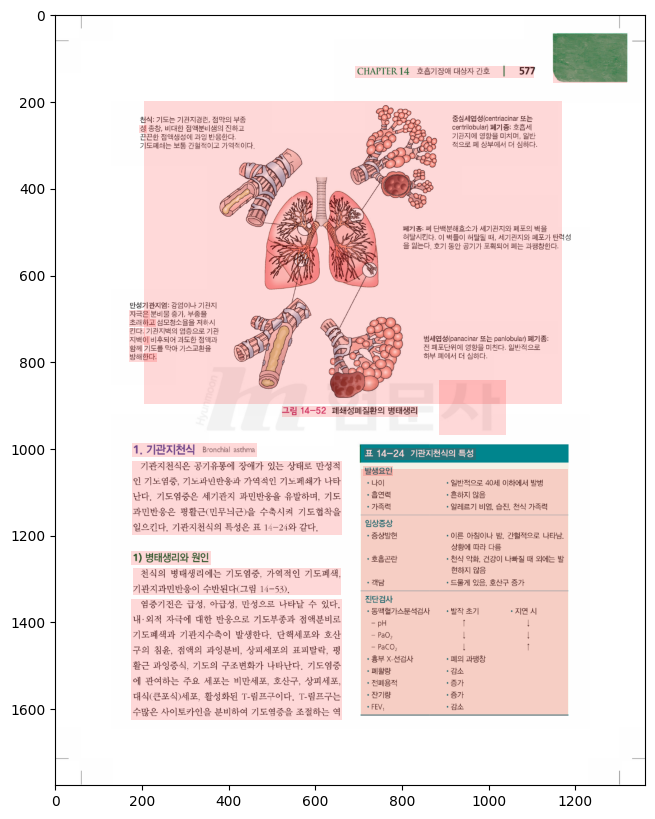

In [83]:
# image에 bounding box 그리기
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
for element in result["elements"]:
    if element["page"] == idx+1:
        x = width*element["coordinates"][0]["x"]
        y = height*element["coordinates"][0]["y"]
        w = width*element["coordinates"][1]["x"] - width*element["coordinates"][0]["x"]
        h = height*element["coordinates"][3]["y"] - height*element["coordinates"][0]["y"]
        rect = patches.Rectangle((x, y), w, h, linewidth=0, edgecolor='r', facecolor='r', alpha=0.15)
        ax.add_patch(rect)
plt.show()
# 0.813, 0.0812


In [57]:
a["elements"]

[{'category': 'header',
  'content': {'html': "<header id='0' style='font-size:18px'>CHAPTER 14 호흡기장애 대상자 간호 I 553</header>",
   'markdown': 'CHAPTER 14 호흡기장애 대상자 간호 I 553',
   'text': 'CHAPTER 14 호흡기장애 대상자 간호 I 553'},
  'coordinates': [{'x': 0.507, 'y': 0.0653},
   {'x': 0.813, 'y': 0.0653},
   {'x': 0.813, 'y': 0.0812},
   {'x': 0.507, 'y': 0.0812}],
  'id': 0,
  'page': 1},
 {'category': 'figure',
  'content': {'html': '<br><figure><img id=\'1\' alt="" data-coord="top-left:(1144,42); bottom-right:(1318,155)" /></figure>',
   'markdown': '',
   'text': ''},
  'coordinates': [{'x': 0.8404, 'y': 0.0239},
   {'x': 0.9677, 'y': 0.0239},
   {'x': 0.9677, 'y': 0.0875},
   {'x': 0.8404, 'y': 0.0875}],
  'id': 1,
  'page': 1},
 {'category': 'heading1',
  'content': {'html': "<h1 id='2' style='font-size:20px'>표 14-15 폐렴 대상자 간호</h1>",
   'markdown': '# 표 14-15 폐렴 대상자 간호',
   'text': '표 14-15 폐렴 대상자 간호'},
  'coordinates': [{'x': 0.1358, 'y': 0.1211},
   {'x': 0.3164, 'y': 0.1211},
   {'x': 0.31